In [ ]:
!pip install textblob
!pip install emoji
!pip install keras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-03-14 13:48:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-14 13:48:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-14 13:48:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Working Code with word embeddings and confusion matrix-unlabelled

In [ ]:
import pandas as pd
import re
import nltk
import emoji
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import MaxPooling1D

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to clean a tweet
def clean_tweet(tweet):
    # Convert to lowercase
    tweet = str(tweet)
    tweet = tweet.lower()

    # Replace URLs with a placeholder
    tweet = re.sub(r'http\S+|www\S+|https\S+', 'URL', tweet, flags=re.MULTILINE)
    # Remove usernames (mentions)
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove emojis and emoticons
    tweet = emoji.demojize(tweet)
    tweet = re.sub(r':[a-z_&]+:', '', tweet)
    # Tokenize the tweet
    tokens = word_tokenize(tweet)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the lemmatized tokens back to form a cleaned tweet
    cleaned_tweet = ' '.join(lemmatized_tokens)

    return cleaned_tweet

# Read the dataset from the Excel file
file_path = '/content/twitter_full_dataset.xlsx'  # Replace with the actual path of your Excel file
df = pd.read_excel(file_path)

# Assuming your tweets are in a column named 'tweet_text'
tweets = df['Text'].tolist()

# Clean each tweet in the dataset
cleaned_tweets = [clean_tweet(tweet) for tweet in tweets]

# Keywords to identify cyberbullying related to racism, sexism, body shaming, and religion bias
racism_keywords = ["black", "white", "racial slur", "race hate", "negro", "nigga"]
sexism_keywords = ["sexist", "sexism", "gender bias", "misogyny", "bitch"]
body_shaming_keywords = ["fat", "skinny", "body hate", "ugly", "weight"]
religion_bias_keywords = ["hindu", "islam", "muslim", "christianity", "terrorist", "jihad"]
hate_speech_keywords = ["slavery","dead","rape","fuck","gay","nasty","rubbish","shit","murder","kill","rapist","homo","asshole","whore","hoe"]

# Lists to store the results
categories = []
sentiment_scores = []
sentiment_labels = []

# Perform sentiment analysis and categorize the tweets
for tweet in cleaned_tweets:
    blob = TextBlob(tweet)
    sentiment_score = blob.sentiment.polarity

    if any(keyword in tweet for keyword in racism_keywords):
        category = "Racism"
    elif any(keyword in tweet for keyword in sexism_keywords):
        category = "Sexism"
    elif any(keyword in tweet for keyword in body_shaming_keywords):
        category = "Body Shaming"
    elif any(keyword in tweet for keyword in religion_bias_keywords):
        category = "Religion Bias"
    elif any(keyword in tweet for keyword in hate_speech_keywords):
        category = "Hate Speech"
    else:
        category = "None"

   # Classify sentiment
    if sentiment_score > 0.2:
        sentiment_label = "Positive"
    elif sentiment_score < -0.2:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"

    categories.append(category)
    sentiment_scores.append(sentiment_score)
    sentiment_labels.append(sentiment_label)

# Create a DataFrame to store the sentiment analysis results
results_df = pd.DataFrame({
    'Cleaned_Tweet': cleaned_tweets,
    'Category': categories,
    'Sentiment Score': sentiment_scores,
    'Sentiment Label': sentiment_labels
})

# Define the path where you want to save the Excel file
excel_file_path = '/content/preprocessed_tweets.xlsx'  # Replace with your desired file path and extension

# Save the DataFrame to an Excel file
results_df.to_excel(excel_file_path, index=False)

# Print a message to confirm that the file has been saved
print(f"Preprocessed dataset with sentiment scores and labels saved to: {excel_file_path}")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = '/content/glove.6B.50d.txt'  # Replace with the actual path of your GloVe file
glove_embeddings = load_glove_embeddings(glove_path)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_tweets)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

sequences = tokenizer.texts_to_sequences(cleaned_tweets)
max_sequence_length = max(len(seq) for seq in sequences)

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Create an embedding matrix
embedding_dim = 50  # Assuming you are using glove.6B.50d.txt

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Separate the features (cleaned tweets) and labels (categories)
X = results_df['Cleaned_Tweet']
y = results_df['Category']

# Encode category labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Reshape train_labels
train_labels = y_encoded.reshape((-1, 1))

# Split the dataset
train_data, test_data, train_labels, test_labels = train_test_split(
    padded_sequences, train_labels, test_size=0.2, random_state=42
)

# Build an LSTM model with GloVe embeddings
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(6, activation='softmax'))  # 6 classes, so the output layer should have 6 neurons and use softmax activation

#compile model
model_lstm.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model
model_lstm.fit(train_data, train_labels, epochs=6, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])

# Evaluate the LSTM model
lstm_predictions = model_lstm.predict(test_data)
lstm_predicted_labels =  np.argmax(lstm_predictions, axis=1)  # Convert probabilities to class labels

class_names = label_encoder.classes_
print("LSTM Classification Report:")
print(classification_report(test_labels, lstm_predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix for LSTM model
lstm_conf_matrix = confusion_matrix(test_labels, lstm_predicted_labels)
print("Confusion Matrix for LSTM Model:\n", lstm_conf_matrix)

num_classes = len(label_encoder.classes_)

from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_encoded = to_categorical(train_labels, num_classes=num_classes)
test_labels_encoded = to_categorical(test_labels, num_classes=num_classes)

# Build a CNN model with GloVe embeddings
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True))
model_cnn.add(Conv1D(128, 6, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model_cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
model_cnn.fit(train_data, train_labels_encoded, epochs=6, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])

# Evaluate the CNN model
cnn_predictions = model_cnn.predict(test_data)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

print("CNN Classification Report:\n", classification_report(test_labels, cnn_predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix for CNN model
cnn_conf_matrix = confusion_matrix(test_labels, cnn_predicted_labels)
print("Confusion Matrix for CNN Model:\n", cnn_conf_matrix)

# Build a hybrid CNN-LSTM model with GloVe embeddings
model_hybrid = Sequential()
model_hybrid.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True))
model_hybrid.add(Conv1D(128, 6, activation='relu'))
model_hybrid.add(MaxPooling1D(pool_size=4))
model_hybrid.add(SpatialDropout1D(0.2))
model_hybrid.add(Bidirectional(LSTM(64)))
model_hybrid.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model_hybrid.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the hybrid CNN-LSTM model
model_hybrid.fit(train_data, train_labels_encoded, epochs=6, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])

# Evaluate the hybrid CNN-LSTM model
hybrid_predictions = model_hybrid.predict(test_data)
hybrid_predicted_labels = np.argmax(hybrid_predictions, axis=1)

print("Hybrid CNN-LSTM Classification Report:\n", classification_report(test_labels, hybrid_predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix for hybrid CNN-LSTM model
hybrid_conf_matrix = confusion_matrix(test_labels, hybrid_predicted_labels)
print("Confusion Matrix for Hybrid CNN-LSTM Model:\n", hybrid_conf_matrix)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Preprocessed dataset with sentiment scores and labels saved to: /content/preprocessed_tweets.xlsx
Epoch 1/6
337/337 [==============================] - 15s 36ms/step - loss: 0.7357 - accuracy: 0.7850 - val_loss: 0.4770 - val_accuracy: 0.8605
Epoch 2/6
337/337 [==============================] - 7s 20ms/step - loss: 0.4023 - accuracy: 0.8763 - val_loss: 0.2872 - val_accuracy: 0.9210
Epoch 3/6
337/337 [==============================] - 9s 28ms/step - loss: 0.2616 - accuracy: 0.9283 - val_loss: 0.1960 - val_accuracy: 0.9544
Epoch 4/6
337/337 [==============================] - 12s 34ms/step - loss: 0.1793 - accuracy: 0.9552 - val_loss: 0.1599 - val_accuracy: 0.9614
Epoch 5/6
337/337 [==============================] - 7s 22ms/step - loss: 0.1390 - accuracy: 0.9669 - val_loss: 0.1516 - val_accuracy: 0.9722
Epoch 6/6
106/106 [==============================] - 1s 7ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

 Body Shaming       0.00      0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/6
337/337 [==============================] - 9s 23ms/step - loss: 0.5198 - accuracy: 0.8463 - val_loss: 0.3314 - val_accuracy: 0.9102
Epoch 2/6
337/337 [==============================] - 6s 17ms/step - loss: 0.2137 - accuracy: 0.9410 - val_loss: 0.2237 - val_accuracy: 0.9429
Epoch 3/6
337/337 [==============================] - 4s 12ms/step - loss: 0.0905 - accuracy: 0.9783 - val_loss: 0.2013 - val_accuracy: 0.9540
Epoch 4/6
337/337 [==============================] - 5s 14ms/step - loss: 0.0330 - accuracy: 0.9928 - val_loss: 0.1863 - val_accuracy: 0.9562
Epoch 5/6
337/337 [==============================] - 7s 20ms/step - loss: 0.0136 - accuracy: 0.9980 - val_loss: 0.2111 - val_accuracy: 0.9566
Epoch 6/6
106/106 [==============================] - 1s 4ms/step
CNN Classification Report:
                precision    recall  f1-score   support

 Body Shaming       0.80      0.17      0.29        23
  Hate Speech       0.90      0.74      0.81       257
         None       0.95      0

Hyperparameter for LSTM

In [ ]:
from keras.utils import to_categorical

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define the function to generate random hyperparameters
def get_hyper_param(n_iteration):
    hyper_param = []  # learning_rate, n_neurons, n_timesteps, n_epochs
    for i in range(n_iteration):
        current_params = []
        current_params.append(np.random.uniform(0, 0.1))  # Learning rate
        current_params.append(np.random.randint(1, 128))   # Number of neurons
        current_params.append(np.random.randint(1, 128))   # Number of timesteps
        current_params.append(np.random.randint(1, 6))    # Number of epochs
        hyper_param.append(current_params)
    return hyper_param

# Generate random hyperparameters
hyper_parameter = get_hyper_param(40)

# Split the dataset (assuming train_data, test_data, train_labels, test_labels are defined)
# Define your own function get_data to get training data and labels based on n_timesteps
# Define top_words and embedding_dimension
top_words = vocab_size
embedding_dimension = embedding_dim

# Define function to fit LSTM model with random hyperparameters
def fit_lstm_random(batch_size):
    min_val_loss = 999
    best_params = None
    for learning_rate, n_neurons, n_timesteps, n_epochs in hyper_parameter:
        print('lr:', learning_rate, 'n_neurons:', n_neurons, 'n_timesteps:', n_timesteps, 'n_epochs:', n_epochs)
        model = Sequential()
        model.add(Embedding(top_words, embedding_dimension, input_length=24, mask_zero=True))  # Set input_length=24
        model.add(LSTM(n_neurons, return_sequences=False))
        model.add(Dense(6, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
        # Fit model

        # Convert integer labels to one-hot encoded format
        train_labels_one_hot = to_categorical(train_labels, num_classes=6)

        # Fit model
        lstm_model = model.fit(train_data, train_labels_one_hot, epochs=n_epochs, batch_size=batch_size, validation_split=0.2, verbose=2)

        current_val_loss = lstm_model.history['val_loss'][-1]
        if current_val_loss < min_val_loss:
            min_val_loss = current_val_loss
            best_params = [learning_rate, n_neurons, n_timesteps, n_epochs]
            print('best_params:', best_params)
    print('final best params:', best_params)
    return best_params

# Define a function to run the random search
def run_lstm_random():
    n_batch = 100
    history = fit_lstm_random(n_batch)

# Run the random search
run_lstm_random()

lr: 0.04734372477625124 n_neurons: 123 n_timesteps: 69 n_epochs: 1


108/108 - 19s - loss: 1.0828 - accuracy: 0.7277 - val_loss: 0.6968 - val_accuracy: 0.8331 - 19s/epoch - 172ms/step
best_params: [0.04734372477625124, 123, 69, 1]
lr: 0.06707988055928135 n_neurons: 90 n_timesteps: 97 n_epochs: 4


Epoch 1/4
108/108 - 15s - loss: 1.0631 - accuracy: 0.7333 - val_loss: 0.6802 - val_accuracy: 0.8327 - 15s/epoch - 137ms/step
Epoch 2/4
108/108 - 12s - loss: 0.3697 - accuracy: 0.9013 - val_loss: 0.3257 - val_accuracy: 0.9358 - 12s/epoch - 114ms/step
Epoch 3/4
108/108 - 7s - loss: 0.1535 - accuracy: 0.9669 - val_loss: 0.2852 - val_accuracy: 0.9384 - 7s/epoch - 60ms/step
Epoch 4/4
108/108 - 11s - loss: 0.0830 - accuracy: 0.9843 - val_loss: 0.2865 - val_accuracy: 0.9306 - 11s/epoch - 101ms/step
best_params: [0.06707988055928135, 90, 97, 4]
lr: 0.09640014633401006 n_neurons: 94 n_timesteps: 53 n_epochs: 5


Epoch 1/5
108/108 - 15s - loss: 1.1051 - accuracy: 0.7219 - val_loss: 0.7445 - val_accuracy: 0.7830 - 15s/epoch - 135ms/step
Epoch 2/5
108/108 - 13s - loss: 0.4160 - accuracy: 0.8838 - val_loss: 0.3216 - val_accuracy: 0.9355 - 13s/epoch - 116ms/step
Epoch 3/5
108/108 - 10s - loss: 0.1551 - accuracy: 0.9658 - val_loss: 0.3106 - val_accuracy: 0.9258 - 10s/epoch - 92ms/step
Epoch 4/5
108/108 - 7s - loss: 0.0857 - accuracy: 0.9820 - val_loss: 0.2519 - val_accuracy: 0.9466 - 7s/epoch - 63ms/step
Epoch 5/5
108/108 - 14s - loss: 0.0508 - accuracy: 0.9915 - val_loss: 0.2552 - val_accuracy: 0.9525 - 14s/epoch - 127ms/step
best_params: [0.09640014633401006, 94, 53, 5]
lr: 0.07602570357161494 n_neurons: 72 n_timesteps: 118 n_epochs: 1


108/108 - 19s - loss: 1.1182 - accuracy: 0.7193 - val_loss: 0.7843 - val_accuracy: 0.7812 - 19s/epoch - 177ms/step
lr: 0.09809338355329829 n_neurons: 70 n_timesteps: 68 n_epochs: 4


Epoch 1/4
108/108 - 17s - loss: 1.1177 - accuracy: 0.7236 - val_loss: 0.7387 - val_accuracy: 0.8116 - 17s/epoch - 153ms/step
Epoch 2/4
108/108 - 7s - loss: 0.4004 - accuracy: 0.8958 - val_loss: 0.3319 - val_accuracy: 0.9284 - 7s/epoch - 66ms/step
Epoch 3/4
108/108 - 5s - loss: 0.1591 - accuracy: 0.9661 - val_loss: 0.3012 - val_accuracy: 0.9325 - 5s/epoch - 46ms/step
Epoch 4/4
108/108 - 8s - loss: 0.0869 - accuracy: 0.9840 - val_loss: 0.2683 - val_accuracy: 0.9418 - 8s/epoch - 74ms/step
lr: 0.06192152011634803 n_neurons: 29 n_timesteps: 1 n_epochs: 1


108/108 - 9s - loss: 1.2362 - accuracy: 0.7079 - val_loss: 0.8915 - val_accuracy: 0.7366 - 9s/epoch - 79ms/step
lr: 0.054905115172551935 n_neurons: 104 n_timesteps: 122 n_epochs: 2


Epoch 1/2
108/108 - 27s - loss: 1.0862 - accuracy: 0.7234 - val_loss: 0.7410 - val_accuracy: 0.7819 - 27s/epoch - 254ms/step
Epoch 2/2
108/108 - 20s - loss: 0.4153 - accuracy: 0.8922 - val_loss: 0.3279 - val_accuracy: 0.9321 - 20s/epoch - 181ms/step
lr: 0.019972683510665536 n_neurons: 9 n_timesteps: 98 n_epochs: 2


Epoch 1/2
108/108 - 24s - loss: 1.3163 - accuracy: 0.7063 - val_loss: 0.9436 - val_accuracy: 0.7374 - 24s/epoch - 218ms/step
Epoch 2/2
108/108 - 6s - loss: 0.7672 - accuracy: 0.7901 - val_loss: 0.6787 - val_accuracy: 0.8398 - 6s/epoch - 52ms/step
lr: 0.025009736981896957 n_neurons: 89 n_timesteps: 13 n_epochs: 1


108/108 - 29s - loss: 1.1100 - accuracy: 0.7226 - val_loss: 0.7436 - val_accuracy: 0.7841 - 29s/epoch - 269ms/step
lr: 0.02049774913423539 n_neurons: 16 n_timesteps: 54 n_epochs: 2


Epoch 1/2
108/108 - 17s - loss: 1.2530 - accuracy: 0.7064 - val_loss: 0.8297 - val_accuracy: 0.7634 - 17s/epoch - 159ms/step
Epoch 2/2
108/108 - 7s - loss: 0.5592 - accuracy: 0.8506 - val_loss: 0.4772 - val_accuracy: 0.8835 - 7s/epoch - 63ms/step
lr: 0.05948929220034882 n_neurons: 2 n_timesteps: 24 n_epochs: 2


Epoch 1/2
108/108 - 9s - loss: 1.6163 - accuracy: 0.7035 - val_loss: 1.3591 - val_accuracy: 0.7277 - 9s/epoch - 81ms/step
Epoch 2/2
108/108 - 4s - loss: 1.1549 - accuracy: 0.7218 - val_loss: 1.0489 - val_accuracy: 0.7322 - 4s/epoch - 39ms/step
lr: 0.01831944883519997 n_neurons: 78 n_timesteps: 44 n_epochs: 5


Epoch 1/5
108/108 - 18s - loss: 1.1151 - accuracy: 0.7221 - val_loss: 0.7737 - val_accuracy: 0.7697 - 18s/epoch - 170ms/step
Epoch 2/5
108/108 - 13s - loss: 0.4546 - accuracy: 0.8789 - val_loss: 0.3480 - val_accuracy: 0.9240 - 13s/epoch - 123ms/step
Epoch 3/5
108/108 - 8s - loss: 0.1695 - accuracy: 0.9608 - val_loss: 0.2838 - val_accuracy: 0.9362 - 8s/epoch - 71ms/step
Epoch 4/5
108/108 - 8s - loss: 0.0955 - accuracy: 0.9777 - val_loss: 0.2360 - val_accuracy: 0.9533 - 8s/epoch - 78ms/step
Epoch 5/5
108/108 - 13s - loss: 0.0584 - accuracy: 0.9875 - val_loss: 0.2384 - val_accuracy: 0.9585 - 13s/epoch - 122ms/step
best_params: [0.01831944883519997, 78, 44, 5]
lr: 0.07641793108399897 n_neurons: 49 n_timesteps: 17 n_epochs: 2


Epoch 1/2
108/108 - 16s - loss: 1.1569 - accuracy: 0.7176 - val_loss: 0.7878 - val_accuracy: 0.7749 - 16s/epoch - 152ms/step
Epoch 2/2
108/108 - 4s - loss: 0.4620 - accuracy: 0.8708 - val_loss: 0.3702 - val_accuracy: 0.9076 - 4s/epoch - 39ms/step
lr: 0.05941522159543571 n_neurons: 109 n_timesteps: 67 n_epochs: 5


Epoch 1/5
108/108 - 21s - loss: 1.0791 - accuracy: 0.7257 - val_loss: 0.6958 - val_accuracy: 0.7867 - 21s/epoch - 195ms/step
Epoch 2/5
108/108 - 9s - loss: 0.3857 - accuracy: 0.8949 - val_loss: 0.3143 - val_accuracy: 0.9388 - 9s/epoch - 81ms/step
Epoch 3/5
108/108 - 12s - loss: 0.1530 - accuracy: 0.9681 - val_loss: 0.2625 - val_accuracy: 0.9458 - 12s/epoch - 115ms/step
Epoch 4/5
108/108 - 12s - loss: 0.0846 - accuracy: 0.9820 - val_loss: 0.2737 - val_accuracy: 0.9507 - 12s/epoch - 112ms/step
Epoch 5/5
108/108 - 9s - loss: 0.0523 - accuracy: 0.9894 - val_loss: 0.2623 - val_accuracy: 0.9529 - 9s/epoch - 85ms/step
lr: 0.0420704458183451 n_neurons: 18 n_timesteps: 24 n_epochs: 2


Epoch 1/2
108/108 - 13s - loss: 1.2586 - accuracy: 0.7031 - val_loss: 0.9185 - val_accuracy: 0.7322 - 13s/epoch - 122ms/step
Epoch 2/2
108/108 - 3s - loss: 0.7180 - accuracy: 0.7940 - val_loss: 0.5773 - val_accuracy: 0.8650 - 3s/epoch - 27ms/step
lr: 0.03941283479026997 n_neurons: 88 n_timesteps: 23 n_epochs: 5


Epoch 1/5
108/108 - 21s - loss: 1.0867 - accuracy: 0.7238 - val_loss: 0.7487 - val_accuracy: 0.7941 - 21s/epoch - 191ms/step
Epoch 2/5
108/108 - 7s - loss: 0.4105 - accuracy: 0.8908 - val_loss: 0.3341 - val_accuracy: 0.9318 - 7s/epoch - 62ms/step
Epoch 3/5
108/108 - 10s - loss: 0.1664 - accuracy: 0.9646 - val_loss: 0.3147 - val_accuracy: 0.9247 - 10s/epoch - 96ms/step
Epoch 4/5
108/108 - 12s - loss: 0.0929 - accuracy: 0.9814 - val_loss: 0.2681 - val_accuracy: 0.9407 - 12s/epoch - 113ms/step
Epoch 5/5
108/108 - 7s - loss: 0.0615 - accuracy: 0.9878 - val_loss: 0.2866 - val_accuracy: 0.9429 - 7s/epoch - 62ms/step
lr: 0.048603810311819456 n_neurons: 104 n_timesteps: 113 n_epochs: 3


Epoch 1/3
108/108 - 16s - loss: 1.0660 - accuracy: 0.7296 - val_loss: 0.6869 - val_accuracy: 0.7927 - 16s/epoch - 146ms/step
Epoch 2/3
108/108 - 14s - loss: 0.3736 - accuracy: 0.9050 - val_loss: 0.3189 - val_accuracy: 0.9366 - 14s/epoch - 128ms/step
Epoch 3/3
108/108 - 10s - loss: 0.1497 - accuracy: 0.9668 - val_loss: 0.2645 - val_accuracy: 0.9488 - 10s/epoch - 92ms/step
lr: 0.09905638330972061 n_neurons: 94 n_timesteps: 106 n_epochs: 4


Epoch 1/4
108/108 - 17s - loss: 1.0805 - accuracy: 0.7254 - val_loss: 0.7250 - val_accuracy: 0.7990 - 17s/epoch - 157ms/step
Epoch 2/4
108/108 - 10s - loss: 0.4394 - accuracy: 0.8716 - val_loss: 0.3703 - val_accuracy: 0.9169 - 10s/epoch - 90ms/step
Epoch 3/4
108/108 - 13s - loss: 0.1793 - accuracy: 0.9590 - val_loss: 0.2694 - val_accuracy: 0.9432 - 13s/epoch - 119ms/step
Epoch 4/4
108/108 - 7s - loss: 0.0906 - accuracy: 0.9807 - val_loss: 0.2532 - val_accuracy: 0.9447 - 7s/epoch - 62ms/step
lr: 0.04994888828509062 n_neurons: 25 n_timesteps: 18 n_epochs: 3


Epoch 1/3
108/108 - 14s - loss: 1.2371 - accuracy: 0.7067 - val_loss: 0.8393 - val_accuracy: 0.7552 - 14s/epoch - 133ms/step
Epoch 2/3
108/108 - 3s - loss: 0.5523 - accuracy: 0.8497 - val_loss: 0.4375 - val_accuracy: 0.8969 - 3s/epoch - 31ms/step
Epoch 3/3
108/108 - 3s - loss: 0.2237 - accuracy: 0.9569 - val_loss: 0.3045 - val_accuracy: 0.9381 - 3s/epoch - 29ms/step
lr: 0.055349801076200106 n_neurons: 55 n_timesteps: 58 n_epochs: 4


Epoch 1/4
108/108 - 15s - loss: 1.1524 - accuracy: 0.7169 - val_loss: 0.8000 - val_accuracy: 0.7634 - 15s/epoch - 137ms/step
Epoch 2/4
108/108 - 4s - loss: 0.4837 - accuracy: 0.8638 - val_loss: 0.3664 - val_accuracy: 0.9206 - 4s/epoch - 38ms/step
Epoch 3/4
108/108 - 5s - loss: 0.1832 - accuracy: 0.9619 - val_loss: 0.2642 - val_accuracy: 0.9525 - 5s/epoch - 45ms/step
Epoch 4/4
108/108 - 7s - loss: 0.0946 - accuracy: 0.9829 - val_loss: 0.2432 - val_accuracy: 0.9503 - 7s/epoch - 64ms/step
lr: 0.044016068494101314 n_neurons: 64 n_timesteps: 33 n_epochs: 1


108/108 - 14s - loss: 1.1144 - accuracy: 0.7218 - val_loss: 0.7622 - val_accuracy: 0.7812 - 14s/epoch - 130ms/step
lr: 0.026404215166720358 n_neurons: 83 n_timesteps: 103 n_epochs: 4


Epoch 1/4
108/108 - 20s - loss: 1.1116 - accuracy: 0.7272 - val_loss: 0.7320 - val_accuracy: 0.8171 - 20s/epoch - 184ms/step
Epoch 2/4
108/108 - 6s - loss: 0.4051 - accuracy: 0.8933 - val_loss: 0.3261 - val_accuracy: 0.9258 - 6s/epoch - 58ms/step
Epoch 3/4
108/108 - 12s - loss: 0.1522 - accuracy: 0.9682 - val_loss: 0.2774 - val_accuracy: 0.9421 - 12s/epoch - 113ms/step
Epoch 4/4
108/108 - 12s - loss: 0.0820 - accuracy: 0.9847 - val_loss: 0.2559 - val_accuracy: 0.9473 - 12s/epoch - 114ms/step
lr: 0.09542030906523918 n_neurons: 9 n_timesteps: 79 n_epochs: 1


108/108 - 9s - loss: 1.3631 - accuracy: 0.6971 - val_loss: 0.9532 - val_accuracy: 0.7341 - 9s/epoch - 87ms/step
lr: 0.048513891640120765 n_neurons: 94 n_timesteps: 43 n_epochs: 5


Epoch 1/5
108/108 - 17s - loss: 1.0976 - accuracy: 0.7272 - val_loss: 0.7350 - val_accuracy: 0.8090 - 17s/epoch - 154ms/step
Epoch 2/5
108/108 - 15s - loss: 0.3828 - accuracy: 0.9043 - val_loss: 0.3153 - val_accuracy: 0.9392 - 15s/epoch - 136ms/step
Epoch 3/5
108/108 - 8s - loss: 0.1540 - accuracy: 0.9670 - val_loss: 0.2995 - val_accuracy: 0.9321 - 8s/epoch - 76ms/step
Epoch 4/5
108/108 - 11s - loss: 0.0843 - accuracy: 0.9829 - val_loss: 0.2573 - val_accuracy: 0.9503 - 11s/epoch - 99ms/step
Epoch 5/5
108/108 - 13s - loss: 0.0542 - accuracy: 0.9891 - val_loss: 0.2480 - val_accuracy: 0.9555 - 13s/epoch - 117ms/step
lr: 0.09863004518837486 n_neurons: 60 n_timesteps: 64 n_epochs: 2


Epoch 1/2
108/108 - 12s - loss: 1.1392 - accuracy: 0.7179 - val_loss: 0.7647 - val_accuracy: 0.7975 - 12s/epoch - 108ms/step
Epoch 2/2
108/108 - 7s - loss: 0.4186 - accuracy: 0.8926 - val_loss: 0.3271 - val_accuracy: 0.9336 - 7s/epoch - 66ms/step
lr: 0.019980612688022606 n_neurons: 75 n_timesteps: 105 n_epochs: 2


Epoch 1/2
108/108 - 13s - loss: 1.1251 - accuracy: 0.7157 - val_loss: 0.7794 - val_accuracy: 0.7812 - 13s/epoch - 117ms/step
Epoch 2/2
108/108 - 12s - loss: 0.4593 - accuracy: 0.8741 - val_loss: 0.3482 - val_accuracy: 0.9247 - 12s/epoch - 114ms/step
lr: 0.06066286000779275 n_neurons: 32 n_timesteps: 85 n_epochs: 1


108/108 - 11s - loss: 1.2143 - accuracy: 0.7115 - val_loss: 0.8385 - val_accuracy: 0.7619 - 11s/epoch - 102ms/step
lr: 0.06403319652523515 n_neurons: 42 n_timesteps: 14 n_epochs: 2


Epoch 1/2
108/108 - 15s - loss: 1.1682 - accuracy: 0.7128 - val_loss: 0.8171 - val_accuracy: 0.7630 - 15s/epoch - 141ms/step
Epoch 2/2
108/108 - 5s - loss: 0.4909 - accuracy: 0.8654 - val_loss: 0.3905 - val_accuracy: 0.9024 - 5s/epoch - 43ms/step
lr: 0.058134301077488584 n_neurons: 110 n_timesteps: 59 n_epochs: 5


Epoch 1/5
108/108 - 21s - loss: 1.0642 - accuracy: 0.7324 - val_loss: 0.6642 - val_accuracy: 0.8238 - 21s/epoch - 196ms/step
Epoch 2/5
108/108 - 10s - loss: 0.3788 - accuracy: 0.9018 - val_loss: 0.3341 - val_accuracy: 0.9277 - 10s/epoch - 91ms/step
Epoch 3/5
108/108 - 15s - loss: 0.1544 - accuracy: 0.9679 - val_loss: 0.2709 - val_accuracy: 0.9384 - 15s/epoch - 139ms/step
Epoch 4/5
108/108 - 8s - loss: 0.0849 - accuracy: 0.9828 - val_loss: 0.2520 - val_accuracy: 0.9455 - 8s/epoch - 73ms/step
Epoch 5/5
108/108 - 15s - loss: 0.0503 - accuracy: 0.9908 - val_loss: 0.2547 - val_accuracy: 0.9540 - 15s/epoch - 139ms/step
lr: 0.029621372101150758 n_neurons: 14 n_timesteps: 43 n_epochs: 4


Epoch 1/4
108/108 - 10s - loss: 1.3153 - accuracy: 0.7028 - val_loss: 0.8877 - val_accuracy: 0.7374 - 10s/epoch - 96ms/step
Epoch 2/4
108/108 - 4s - loss: 0.6698 - accuracy: 0.8093 - val_loss: 0.5885 - val_accuracy: 0.8583 - 4s/epoch - 36ms/step
Epoch 3/4
108/108 - 5s - loss: 0.3831 - accuracy: 0.8960 - val_loss: 0.4248 - val_accuracy: 0.8939 - 5s/epoch - 45ms/step
Epoch 4/4
108/108 - 5s - loss: 0.2358 - accuracy: 0.9404 - val_loss: 0.3493 - val_accuracy: 0.9221 - 5s/epoch - 46ms/step
lr: 0.01806219916791333 n_neurons: 78 n_timesteps: 113 n_epochs: 5


Epoch 1/5
108/108 - 14s - loss: 1.1208 - accuracy: 0.7195 - val_loss: 0.7567 - val_accuracy: 0.7786 - 14s/epoch - 126ms/step
Epoch 2/5
108/108 - 14s - loss: 0.4290 - accuracy: 0.8881 - val_loss: 0.3460 - val_accuracy: 0.9254 - 14s/epoch - 126ms/step
Epoch 3/5
108/108 - 7s - loss: 0.1641 - accuracy: 0.9650 - val_loss: 0.2751 - val_accuracy: 0.9477 - 7s/epoch - 68ms/step
Epoch 4/5
108/108 - 8s - loss: 0.0876 - accuracy: 0.9829 - val_loss: 0.2655 - val_accuracy: 0.9436 - 8s/epoch - 72ms/step
Epoch 5/5
108/108 - 14s - loss: 0.0541 - accuracy: 0.9898 - val_loss: 0.2480 - val_accuracy: 0.9599 - 14s/epoch - 127ms/step
lr: 0.0998037152929798 n_neurons: 101 n_timesteps: 63 n_epochs: 4


Epoch 1/4
108/108 - 24s - loss: 1.1003 - accuracy: 0.7225 - val_loss: 0.7497 - val_accuracy: 0.7889 - 24s/epoch - 220ms/step
Epoch 2/4
108/108 - 8s - loss: 0.4055 - accuracy: 0.8871 - val_loss: 0.3144 - val_accuracy: 0.9381 - 8s/epoch - 70ms/step
Epoch 3/4
108/108 - 14s - loss: 0.1534 - accuracy: 0.9646 - val_loss: 0.2452 - val_accuracy: 0.9514 - 14s/epoch - 133ms/step
Epoch 4/4
108/108 - 10s - loss: 0.0819 - accuracy: 0.9856 - val_loss: 0.2532 - val_accuracy: 0.9470 - 10s/epoch - 92ms/step
lr: 0.09669138446360118 n_neurons: 5 n_timesteps: 14 n_epochs: 1


108/108 - 12s - loss: 1.4849 - accuracy: 0.6979 - val_loss: 1.1407 - val_accuracy: 0.7322 - 12s/epoch - 112ms/step
lr: 0.04003471225900401 n_neurons: 29 n_timesteps: 34 n_epochs: 5


Epoch 1/5
108/108 - 13s - loss: 1.2224 - accuracy: 0.7154 - val_loss: 0.8307 - val_accuracy: 0.7719 - 13s/epoch - 117ms/step
Epoch 2/5
108/108 - 6s - loss: 0.5205 - accuracy: 0.8596 - val_loss: 0.3803 - val_accuracy: 0.9062 - 6s/epoch - 56ms/step
Epoch 3/5
108/108 - 5s - loss: 0.2082 - accuracy: 0.9547 - val_loss: 0.3113 - val_accuracy: 0.9321 - 5s/epoch - 43ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1172 - accuracy: 0.9795 - val_loss: 0.2535 - val_accuracy: 0.9481 - 3s/epoch - 31ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0793 - accuracy: 0.9855 - val_loss: 0.2852 - val_accuracy: 0.9314 - 3s/epoch - 30ms/step
lr: 0.060657719537704595 n_neurons: 93 n_timesteps: 39 n_epochs: 3


Epoch 1/3
108/108 - 21s - loss: 1.0864 - accuracy: 0.7273 - val_loss: 0.7395 - val_accuracy: 0.8023 - 21s/epoch - 192ms/step
Epoch 2/3
108/108 - 7s - loss: 0.3935 - accuracy: 0.9020 - val_loss: 0.3082 - val_accuracy: 0.9351 - 7s/epoch - 68ms/step
Epoch 3/3
108/108 - 15s - loss: 0.1467 - accuracy: 0.9688 - val_loss: 0.2584 - val_accuracy: 0.9481 - 15s/epoch - 136ms/step
lr: 0.014028434520376422 n_neurons: 4 n_timesteps: 37 n_epochs: 5


Epoch 1/5
108/108 - 10s - loss: 1.4913 - accuracy: 0.7022 - val_loss: 1.1278 - val_accuracy: 0.7251 - 10s/epoch - 90ms/step
Epoch 2/5
108/108 - 3s - loss: 0.9958 - accuracy: 0.7195 - val_loss: 0.9404 - val_accuracy: 0.7285 - 3s/epoch - 32ms/step
Epoch 3/5
108/108 - 4s - loss: 0.8260 - accuracy: 0.7499 - val_loss: 0.7945 - val_accuracy: 0.7652 - 4s/epoch - 41ms/step
Epoch 4/5
108/108 - 4s - loss: 0.6355 - accuracy: 0.7946 - val_loss: 0.6374 - val_accuracy: 0.7927 - 4s/epoch - 41ms/step
Epoch 5/5
108/108 - 4s - loss: 0.5117 - accuracy: 0.8138 - val_loss: 0.5517 - val_accuracy: 0.8231 - 4s/epoch - 41ms/step
lr: 0.06112449693857561 n_neurons: 41 n_timesteps: 41 n_epochs: 1


108/108 - 12s - loss: 1.1827 - accuracy: 0.7131 - val_loss: 0.8266 - val_accuracy: 0.7548 - 12s/epoch - 108ms/step
lr: 0.02206278229569443 n_neurons: 20 n_timesteps: 45 n_epochs: 5


Epoch 1/5
108/108 - 13s - loss: 1.2351 - accuracy: 0.7081 - val_loss: 0.8960 - val_accuracy: 0.7352 - 13s/epoch - 119ms/step
Epoch 2/5
108/108 - 5s - loss: 0.6950 - accuracy: 0.7973 - val_loss: 0.5665 - val_accuracy: 0.8698 - 5s/epoch - 49ms/step
Epoch 3/5
108/108 - 4s - loss: 0.3092 - accuracy: 0.9285 - val_loss: 0.3168 - val_accuracy: 0.9381 - 4s/epoch - 34ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1411 - accuracy: 0.9757 - val_loss: 0.2609 - val_accuracy: 0.9492 - 3s/epoch - 28ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0856 - accuracy: 0.9839 - val_loss: 0.2422 - val_accuracy: 0.9477 - 3s/epoch - 29ms/step
lr: 0.04119798480229449 n_neurons: 53 n_timesteps: 53 n_epochs: 2


Epoch 1/2
108/108 - 14s - loss: 1.1418 - accuracy: 0.7182 - val_loss: 0.8185 - val_accuracy: 0.7711 - 14s/epoch - 133ms/step
Epoch 2/2
108/108 - 7s - loss: 0.5136 - accuracy: 0.8597 - val_loss: 0.3971 - val_accuracy: 0.9088 - 7s/epoch - 68ms/step
lr: 0.008731542206220267 n_neurons: 55 n_timesteps: 121 n_epochs: 5


Epoch 1/5
108/108 - 12s - loss: 1.1581 - accuracy: 0.7180 - val_loss: 0.7820 - val_accuracy: 0.7930 - 12s/epoch - 108ms/step
Epoch 2/5
108/108 - 7s - loss: 0.4451 - accuracy: 0.8814 - val_loss: 0.3602 - val_accuracy: 0.9210 - 7s/epoch - 65ms/step
Epoch 3/5
108/108 - 7s - loss: 0.1830 - accuracy: 0.9575 - val_loss: 0.2757 - val_accuracy: 0.9462 - 7s/epoch - 64ms/step
Epoch 4/5
108/108 - 4s - loss: 0.0953 - accuracy: 0.9828 - val_loss: 0.2854 - val_accuracy: 0.9410 - 4s/epoch - 38ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0627 - accuracy: 0.9894 - val_loss: 0.2567 - val_accuracy: 0.9499 - 4s/epoch - 38ms/step
final best params: [0.01831944883519997, 78, 44, 5]


In [ ]:
# Define the LSTM model with the best parameters
best_learning_rate = 0.01831944883519997
best_n_neurons = 78
best_n_timesteps = 44
best_n_epochs = 5

# Define and compile the model
model = Sequential()
model.add(Embedding(top_words, embedding_dimension, input_length=24, mask_zero=True))
model.add(LSTM(best_n_neurons, return_sequences=False))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=best_learning_rate), metrics=['accuracy'])

# Convert integer labels to one-hot encoded format for the entire training set
train_labels_one_hot = to_categorical(train_labels, num_classes=6)

# Train the model on the entire training dataset
model.fit(train_data, train_labels_one_hot, epochs=best_n_epochs, batch_size=100, verbose=2)

test_labels_one_hot = to_categorical(test_labels, num_classes=6)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data, test_labels_one_hot, verbose=2)

print("Test Accuracy:", test_accuracy)


Epoch 1/5
135/135 - 22s - loss: 1.0407 - accuracy: 0.7386 - 22s/epoch - 161ms/step
Epoch 2/5
135/135 - 15s - loss: 0.3188 - accuracy: 0.9223 - 15s/epoch - 114ms/step
Epoch 3/5
135/135 - 7s - loss: 0.1302 - accuracy: 0.9734 - 7s/epoch - 52ms/step
Epoch 4/5
135/135 - 11s - loss: 0.0715 - accuracy: 0.9842 - 11s/epoch - 83ms/step
Epoch 5/5
135/135 - 12s - loss: 0.0455 - accuracy: 0.9912 - 12s/epoch - 90ms/step
106/106 - 2s - loss: 0.1931 - accuracy: 0.9644 - 2s/epoch - 20ms/step
Test Accuracy: 0.9644022583961487


CNN Hyperparameter

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define the function to generate random hyperparameters
def get_hyper_param(n_iteration):
    hyper_param = []  # learning_rate, num_filters, filter_size, dense_units
    for i in range(n_iteration):
        current_params = []
        current_params.append(np.random.uniform(0.001, 0.01))  # Learning rate
        current_params.append(np.random.randint(64, 128))  # Number of filters
        current_params.append(np.random.randint(3, 7))  # Filter size
        current_params.append(np.random.randint(32, 64))  # Number of units in the dense layer
        hyper_param.append(current_params)
    return hyper_param

# Generate random hyperparameters
hyper_parameter = get_hyper_param(40)

# Split the dataset (assuming train_data, test_data, train_labels, test_labels are defined)
# Define your own function get_data to get training data and labels
#train_data, test_data, train_labels, test_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define function to create and compile CNN model with specific hyperparameters
def create_cnn_model(learning_rate, num_filters, filter_size, dense_units):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True))
    model.add(Conv1D(num_filters, filter_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define function to fit CNN model with random hyperparameters
def fit_cnn_random(batch_size):
    min_val_loss = 999
    best_params = None
    for learning_rate, num_filters, filter_size, dense_units in hyper_parameter:
        print('lr:', learning_rate, 'num_filters:', num_filters, 'filter_size:', filter_size, 'dense_units:', dense_units)
        model = create_cnn_model(learning_rate, num_filters, filter_size, dense_units)
        # Convert labels to one-hot encoding
        train_labels_encoded = to_categorical(train_labels, num_classes=num_classes)
        # Fit model
        cnn_model = model.fit(train_data, train_labels_encoded, epochs=5, batch_size=batch_size, validation_split=0.2, verbose=2)
        current_val_loss = cnn_model.history['val_loss'][-1]
        if current_val_loss < min_val_loss:
            min_val_loss = current_val_loss
            best_params = [learning_rate, num_filters, filter_size, dense_units]
            print('best_params:', best_params)
    print('final best params:', best_params)
    return best_params

# Define a function to run the random search
def run_cnn_random():
    n_batch = 100
    history = fit_cnn_random(n_batch)

# Run the random search
run_cnn_random()

lr: 0.00558635205937136 num_filters: 93 filter_size: 6 dense_units: 46


Epoch 1/5
108/108 - 4s - loss: 0.7211 - accuracy: 0.7851 - val_loss: 0.4621 - val_accuracy: 0.8769 - 4s/epoch - 41ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3558 - accuracy: 0.8911 - val_loss: 0.3347 - val_accuracy: 0.9062 - 3s/epoch - 26ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2211 - accuracy: 0.9386 - val_loss: 0.2856 - val_accuracy: 0.9188 - 3s/epoch - 32ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1316 - accuracy: 0.9664 - val_loss: 0.2346 - val_accuracy: 0.9410 - 4s/epoch - 33ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0735 - accuracy: 0.9843 - val_loss: 0.2189 - val_accuracy: 0.9425 - 4s/epoch - 35ms/step


best_params: [0.00558635205937136, 93, 6, 46]
lr: 0.0051629168478147065 num_filters: 66 filter_size: 3 dense_units: 58
Epoch 1/5
108/108 - 3s - loss: 0.7100 - accuracy: 0.8004 - val_loss: 0.4532 - val_accuracy: 0.8731 - 3s/epoch - 25ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3747 - accuracy: 0.8860 - val_loss: 0.3288 - val_accuracy: 0.9106 - 2s/epoch - 16ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2480 - accuracy: 0.9281 - val_loss: 0.2625 - val_accuracy: 0.9325 - 2s/epoch - 15ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1650 - accuracy: 0.9586 - val_loss: 0.2205 - val_accuracy: 0.9496 - 2s/epoch - 15ms/step
Epoch 5/5
108/108 - 2s - loss: 0.1077 - accuracy: 0.9747 - val_loss: 0.2012 - val_accuracy: 0.9551 - 2s/epoch - 15ms/step


best_params: [0.0051629168478147065, 66, 3, 58]
lr: 0.001256309634630325 num_filters: 85 filter_size: 4 dense_units: 34
Epoch 1/5
108/108 - 5s - loss: 0.7143 - accuracy: 0.7929 - val_loss: 0.4631 - val_accuracy: 0.8717 - 5s/epoch - 48ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3596 - accuracy: 0.8917 - val_loss: 0.3401 - val_accuracy: 0.9050 - 3s/epoch - 30ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2328 - accuracy: 0.9363 - val_loss: 0.2688 - val_accuracy: 0.9299 - 3s/epoch - 28ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1495 - accuracy: 0.9613 - val_loss: 0.2343 - val_accuracy: 0.9418 - 3s/epoch - 28ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0926 - accuracy: 0.9782 - val_loss: 0.2107 - val_accuracy: 0.9507 - 3s/epoch - 25ms/step


lr: 0.005472162212563584 num_filters: 109 filter_size: 5 dense_units: 47
Epoch 1/5
108/108 - 3s - loss: 0.7581 - accuracy: 0.7713 - val_loss: 0.4825 - val_accuracy: 0.8635 - 3s/epoch - 29ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3809 - accuracy: 0.8866 - val_loss: 0.3383 - val_accuracy: 0.9047 - 3s/epoch - 23ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2368 - accuracy: 0.9372 - val_loss: 0.2698 - val_accuracy: 0.9240 - 4s/epoch - 32ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1484 - accuracy: 0.9640 - val_loss: 0.2256 - val_accuracy: 0.9410 - 4s/epoch - 34ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0902 - accuracy: 0.9789 - val_loss: 0.2075 - val_accuracy: 0.9492 - 4s/epoch - 34ms/step


lr: 0.006935708171469271 num_filters: 114 filter_size: 3 dense_units: 52
Epoch 1/5
108/108 - 5s - loss: 0.6256 - accuracy: 0.8143 - val_loss: 0.4232 - val_accuracy: 0.8895 - 5s/epoch - 47ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3370 - accuracy: 0.9031 - val_loss: 0.2924 - val_accuracy: 0.9221 - 2s/epoch - 22ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2099 - accuracy: 0.9442 - val_loss: 0.2284 - val_accuracy: 0.9407 - 2s/epoch - 17ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1317 - accuracy: 0.9675 - val_loss: 0.2010 - val_accuracy: 0.9514 - 2s/epoch - 18ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0815 - accuracy: 0.9798 - val_loss: 0.1797 - val_accuracy: 0.9544 - 2s/epoch - 18ms/step


best_params: [0.006935708171469271, 114, 3, 52]
lr: 0.00560317555318671 num_filters: 98 filter_size: 4 dense_units: 33
Epoch 1/5
108/108 - 3s - loss: 0.7269 - accuracy: 0.7855 - val_loss: 0.4680 - val_accuracy: 0.8698 - 3s/epoch - 28ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3666 - accuracy: 0.8897 - val_loss: 0.3224 - val_accuracy: 0.9088 - 3s/epoch - 28ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2303 - accuracy: 0.9370 - val_loss: 0.2608 - val_accuracy: 0.9277 - 3s/epoch - 30ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1440 - accuracy: 0.9617 - val_loss: 0.2077 - val_accuracy: 0.9466 - 3s/epoch - 31ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0863 - accuracy: 0.9791 - val_loss: 0.1889 - val_accuracy: 0.9536 - 3s/epoch - 32ms/step


lr: 0.006488421170641201 num_filters: 127 filter_size: 4 dense_units: 47
Epoch 1/5
108/108 - 5s - loss: 0.6287 - accuracy: 0.8150 - val_loss: 0.4149 - val_accuracy: 0.8835 - 5s/epoch - 50ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3253 - accuracy: 0.9037 - val_loss: 0.2973 - val_accuracy: 0.9199 - 2s/epoch - 20ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2005 - accuracy: 0.9464 - val_loss: 0.2374 - val_accuracy: 0.9373 - 2s/epoch - 19ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1208 - accuracy: 0.9699 - val_loss: 0.2146 - val_accuracy: 0.9473 - 2s/epoch - 19ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0699 - accuracy: 0.9844 - val_loss: 0.2012 - val_accuracy: 0.9540 - 2s/epoch - 19ms/step


lr: 0.009390806809297252 num_filters: 92 filter_size: 3 dense_units: 54
Epoch 1/5
108/108 - 7s - loss: 0.6967 - accuracy: 0.7882 - val_loss: 0.4491 - val_accuracy: 0.8735 - 7s/epoch - 66ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3628 - accuracy: 0.8923 - val_loss: 0.3209 - val_accuracy: 0.9132 - 2s/epoch - 21ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2347 - accuracy: 0.9361 - val_loss: 0.2487 - val_accuracy: 0.9347 - 2s/epoch - 17ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1521 - accuracy: 0.9606 - val_loss: 0.2120 - val_accuracy: 0.9481 - 2s/epoch - 16ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0977 - accuracy: 0.9762 - val_loss: 0.1917 - val_accuracy: 0.9507 - 2s/epoch - 17ms/step


lr: 0.007973765373272663 num_filters: 84 filter_size: 4 dense_units: 63
Epoch 1/5
108/108 - 3s - loss: 0.7821 - accuracy: 0.7650 - val_loss: 0.4712 - val_accuracy: 0.8668 - 3s/epoch - 27ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3700 - accuracy: 0.8938 - val_loss: 0.3268 - val_accuracy: 0.9099 - 3s/epoch - 24ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2415 - accuracy: 0.9337 - val_loss: 0.2667 - val_accuracy: 0.9295 - 3s/epoch - 29ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1537 - accuracy: 0.9609 - val_loss: 0.2245 - val_accuracy: 0.9421 - 3s/epoch - 28ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0949 - accuracy: 0.9773 - val_loss: 0.2091 - val_accuracy: 0.9462 - 3s/epoch - 28ms/step


lr: 0.008904640041883672 num_filters: 71 filter_size: 5 dense_units: 35
Epoch 1/5
108/108 - 5s - loss: 0.8900 - accuracy: 0.7323 - val_loss: 0.5263 - val_accuracy: 0.8524 - 5s/epoch - 48ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4217 - accuracy: 0.8724 - val_loss: 0.3731 - val_accuracy: 0.8913 - 3s/epoch - 24ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2802 - accuracy: 0.9196 - val_loss: 0.2932 - val_accuracy: 0.9203 - 2s/epoch - 17ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1849 - accuracy: 0.9542 - val_loss: 0.2533 - val_accuracy: 0.9343 - 2s/epoch - 17ms/step
Epoch 5/5
108/108 - 2s - loss: 0.1230 - accuracy: 0.9700 - val_loss: 0.2231 - val_accuracy: 0.9462 - 2s/epoch - 17ms/step


lr: 0.0019371838635410987 num_filters: 93 filter_size: 4 dense_units: 62
Epoch 1/5
108/108 - 5s - loss: 0.7559 - accuracy: 0.7714 - val_loss: 0.4841 - val_accuracy: 0.8616 - 5s/epoch - 49ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3879 - accuracy: 0.8802 - val_loss: 0.3289 - val_accuracy: 0.9062 - 3s/epoch - 30ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2463 - accuracy: 0.9295 - val_loss: 0.2521 - val_accuracy: 0.9321 - 3s/epoch - 26ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1528 - accuracy: 0.9608 - val_loss: 0.2176 - val_accuracy: 0.9425 - 2s/epoch - 18ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0951 - accuracy: 0.9764 - val_loss: 0.2001 - val_accuracy: 0.9488 - 2s/epoch - 17ms/step


lr: 0.0028220778643599518 num_filters: 104 filter_size: 5 dense_units: 61
Epoch 1/5
108/108 - 3s - loss: 0.7747 - accuracy: 0.7715 - val_loss: 0.4667 - val_accuracy: 0.8598 - 3s/epoch - 30ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3642 - accuracy: 0.8919 - val_loss: 0.3243 - val_accuracy: 0.9132 - 2s/epoch - 21ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2257 - accuracy: 0.9378 - val_loss: 0.2526 - val_accuracy: 0.9358 - 4s/epoch - 33ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1400 - accuracy: 0.9656 - val_loss: 0.2192 - val_accuracy: 0.9477 - 4s/epoch - 33ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0831 - accuracy: 0.9802 - val_loss: 0.2010 - val_accuracy: 0.9503 - 4s/epoch - 34ms/step


lr: 0.009641610804602314 num_filters: 97 filter_size: 4 dense_units: 45
Epoch 1/5
108/108 - 3s - loss: 0.7813 - accuracy: 0.7567 - val_loss: 0.4877 - val_accuracy: 0.8568 - 3s/epoch - 29ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3782 - accuracy: 0.8868 - val_loss: 0.3447 - val_accuracy: 0.9028 - 2s/epoch - 18ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2398 - accuracy: 0.9330 - val_loss: 0.2706 - val_accuracy: 0.9277 - 2s/epoch - 18ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1513 - accuracy: 0.9613 - val_loss: 0.2332 - val_accuracy: 0.9347 - 2s/epoch - 17ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0928 - accuracy: 0.9781 - val_loss: 0.2149 - val_accuracy: 0.9418 - 2s/epoch - 20ms/step


lr: 0.0071065562279736755 num_filters: 81 filter_size: 4 dense_units: 57
Epoch 1/5
108/108 - 5s - loss: 0.7487 - accuracy: 0.7739 - val_loss: 0.4725 - val_accuracy: 0.8628 - 5s/epoch - 45ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3745 - accuracy: 0.8833 - val_loss: 0.3264 - val_accuracy: 0.9069 - 3s/epoch - 29ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2372 - accuracy: 0.9338 - val_loss: 0.2619 - val_accuracy: 0.9332 - 3s/epoch - 30ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1543 - accuracy: 0.9602 - val_loss: 0.2326 - val_accuracy: 0.9366 - 3s/epoch - 30ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0960 - accuracy: 0.9767 - val_loss: 0.2116 - val_accuracy: 0.9455 - 3s/epoch - 27ms/step


lr: 0.00964996768411452 num_filters: 68 filter_size: 4 dense_units: 43
Epoch 1/5
108/108 - 3s - loss: 0.7662 - accuracy: 0.7715 - val_loss: 0.5159 - val_accuracy: 0.8520 - 3s/epoch - 26ms/step
Epoch 2/5
108/108 - 2s - loss: 0.4067 - accuracy: 0.8785 - val_loss: 0.3684 - val_accuracy: 0.8935 - 2s/epoch - 16ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2728 - accuracy: 0.9216 - val_loss: 0.2916 - val_accuracy: 0.9228 - 2s/epoch - 16ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1792 - accuracy: 0.9515 - val_loss: 0.2427 - val_accuracy: 0.9384 - 2s/epoch - 16ms/step
Epoch 5/5
108/108 - 2s - loss: 0.1158 - accuracy: 0.9719 - val_loss: 0.2201 - val_accuracy: 0.9440 - 2s/epoch - 16ms/step


lr: 0.004749674114158666 num_filters: 83 filter_size: 3 dense_units: 57
Epoch 1/5
108/108 - 5s - loss: 0.6786 - accuracy: 0.8011 - val_loss: 0.4491 - val_accuracy: 0.8713 - 5s/epoch - 44ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3469 - accuracy: 0.8996 - val_loss: 0.3041 - val_accuracy: 0.9195 - 3s/epoch - 29ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2222 - accuracy: 0.9414 - val_loss: 0.2428 - val_accuracy: 0.9399 - 3s/epoch - 29ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1469 - accuracy: 0.9610 - val_loss: 0.2042 - val_accuracy: 0.9518 - 3s/epoch - 31ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0931 - accuracy: 0.9766 - val_loss: 0.1829 - val_accuracy: 0.9577 - 3s/epoch - 28ms/step
lr: 0.0038547525422791495 num_filters: 98 filter_size: 4 dense_units: 38


Epoch 1/5
108/108 - 5s - loss: 0.7118 - accuracy: 0.7871 - val_loss: 0.4625 - val_accuracy: 0.8731 - 5s/epoch - 42ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3677 - accuracy: 0.8897 - val_loss: 0.3236 - val_accuracy: 0.9162 - 3s/epoch - 24ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2304 - accuracy: 0.9392 - val_loss: 0.2574 - val_accuracy: 0.9355 - 3s/epoch - 31ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1503 - accuracy: 0.9598 - val_loss: 0.2268 - val_accuracy: 0.9421 - 4s/epoch - 39ms/step
Epoch 5/5
108/108 - 6s - loss: 0.0926 - accuracy: 0.9757 - val_loss: 0.1947 - val_accuracy: 0.9473 - 6s/epoch - 51ms/step
lr: 0.008506413886170006 num_filters: 112 filter_size: 4 dense_units: 57


Epoch 1/5
108/108 - 8s - loss: 0.6740 - accuracy: 0.7952 - val_loss: 0.4418 - val_accuracy: 0.8743 - 8s/epoch - 77ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3448 - accuracy: 0.8941 - val_loss: 0.3063 - val_accuracy: 0.9147 - 3s/epoch - 27ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2135 - accuracy: 0.9435 - val_loss: 0.2478 - val_accuracy: 0.9355 - 4s/epoch - 36ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1303 - accuracy: 0.9677 - val_loss: 0.2217 - val_accuracy: 0.9425 - 4s/epoch - 38ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0778 - accuracy: 0.9815 - val_loss: 0.2026 - val_accuracy: 0.9514 - 3s/epoch - 31ms/step


lr: 0.007481130211933103 num_filters: 122 filter_size: 5 dense_units: 61
Epoch 1/5
108/108 - 6s - loss: 0.7844 - accuracy: 0.7604 - val_loss: 0.4764 - val_accuracy: 0.8550 - 6s/epoch - 54ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3706 - accuracy: 0.8884 - val_loss: 0.3226 - val_accuracy: 0.9121 - 2s/epoch - 22ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2223 - accuracy: 0.9381 - val_loss: 0.2499 - val_accuracy: 0.9358 - 2s/epoch - 21ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1317 - accuracy: 0.9654 - val_loss: 0.2088 - val_accuracy: 0.9451 - 2s/epoch - 21ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0717 - accuracy: 0.9836 - val_loss: 0.1911 - val_accuracy: 0.9525 - 2s/epoch - 21ms/step


lr: 0.0074905815154723025 num_filters: 119 filter_size: 6 dense_units: 42
Epoch 1/5
108/108 - 5s - loss: 0.6445 - accuracy: 0.8072 - val_loss: 0.4394 - val_accuracy: 0.8705 - 5s/epoch - 46ms/step
Epoch 2/5
108/108 - 4s - loss: 0.3280 - accuracy: 0.9021 - val_loss: 0.3124 - val_accuracy: 0.9095 - 4s/epoch - 38ms/step
Epoch 3/5
108/108 - 4s - loss: 0.1963 - accuracy: 0.9462 - val_loss: 0.2629 - val_accuracy: 0.9247 - 4s/epoch - 38ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1123 - accuracy: 0.9732 - val_loss: 0.2353 - val_accuracy: 0.9366 - 4s/epoch - 38ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0626 - accuracy: 0.9866 - val_loss: 0.2235 - val_accuracy: 0.9473 - 4s/epoch - 33ms/step


lr: 0.0027511601815357967 num_filters: 100 filter_size: 3 dense_units: 48
Epoch 1/5
108/108 - 3s - loss: 0.8061 - accuracy: 0.7503 - val_loss: 0.4720 - val_accuracy: 0.8609 - 3s/epoch - 27ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3759 - accuracy: 0.8903 - val_loss: 0.3280 - val_accuracy: 0.9128 - 2s/epoch - 17ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2431 - accuracy: 0.9357 - val_loss: 0.2565 - val_accuracy: 0.9318 - 2s/epoch - 17ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1563 - accuracy: 0.9599 - val_loss: 0.2215 - val_accuracy: 0.9399 - 2s/epoch - 17ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0981 - accuracy: 0.9764 - val_loss: 0.1923 - val_accuracy: 0.9547 - 3s/epoch - 26ms/step
lr: 0.0037095091804243557 num_filters: 91 filter_size: 5 dense_units: 55


Epoch 1/5
108/108 - 5s - loss: 0.7513 - accuracy: 0.7780 - val_loss: 0.4778 - val_accuracy: 0.8605 - 5s/epoch - 48ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3804 - accuracy: 0.8838 - val_loss: 0.3425 - val_accuracy: 0.9054 - 2s/epoch - 19ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2433 - accuracy: 0.9318 - val_loss: 0.2681 - val_accuracy: 0.9299 - 2s/epoch - 20ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1543 - accuracy: 0.9599 - val_loss: 0.2282 - val_accuracy: 0.9381 - 2s/epoch - 20ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0900 - accuracy: 0.9790 - val_loss: 0.2060 - val_accuracy: 0.9440 - 3s/epoch - 28ms/step


lr: 0.009986675472557844 num_filters: 127 filter_size: 4 dense_units: 56
Epoch 1/5
108/108 - 6s - loss: 0.6280 - accuracy: 0.8158 - val_loss: 0.4098 - val_accuracy: 0.8858 - 6s/epoch - 53ms/step
Epoch 2/5
108/108 - 4s - loss: 0.3247 - accuracy: 0.9020 - val_loss: 0.3041 - val_accuracy: 0.9228 - 4s/epoch - 35ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2046 - accuracy: 0.9437 - val_loss: 0.2498 - val_accuracy: 0.9347 - 4s/epoch - 36ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1308 - accuracy: 0.9664 - val_loss: 0.2191 - val_accuracy: 0.9462 - 4s/epoch - 35ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0768 - accuracy: 0.9812 - val_loss: 0.2102 - val_accuracy: 0.9496 - 2s/epoch - 20ms/step


lr: 0.0010676312100713506 num_filters: 86 filter_size: 6 dense_units: 56
Epoch 1/5
108/108 - 3s - loss: 0.6904 - accuracy: 0.7889 - val_loss: 0.4564 - val_accuracy: 0.8613 - 3s/epoch - 30ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3575 - accuracy: 0.8893 - val_loss: 0.3535 - val_accuracy: 0.8913 - 2s/epoch - 20ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2180 - accuracy: 0.9378 - val_loss: 0.2570 - val_accuracy: 0.9332 - 3s/epoch - 25ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1292 - accuracy: 0.9671 - val_loss: 0.2279 - val_accuracy: 0.9381 - 4s/epoch - 34ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0731 - accuracy: 0.9841 - val_loss: 0.2142 - val_accuracy: 0.9484 - 4s/epoch - 34ms/step


lr: 0.004480610319910649 num_filters: 102 filter_size: 3 dense_units: 49
Epoch 1/5
108/108 - 5s - loss: 0.6559 - accuracy: 0.8157 - val_loss: 0.4295 - val_accuracy: 0.8776 - 5s/epoch - 46ms/step
Epoch 2/5
108/108 - 4s - loss: 0.3442 - accuracy: 0.8986 - val_loss: 0.3060 - val_accuracy: 0.9169 - 4s/epoch - 33ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2196 - accuracy: 0.9399 - val_loss: 0.2427 - val_accuracy: 0.9343 - 2s/epoch - 21ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1386 - accuracy: 0.9639 - val_loss: 0.2112 - val_accuracy: 0.9451 - 2s/epoch - 17ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0839 - accuracy: 0.9799 - val_loss: 0.1929 - val_accuracy: 0.9518 - 2s/epoch - 17ms/step


lr: 0.0030185187992964042 num_filters: 87 filter_size: 3 dense_units: 60
Epoch 1/5
108/108 - 3s - loss: 0.7168 - accuracy: 0.7898 - val_loss: 0.4534 - val_accuracy: 0.8713 - 3s/epoch - 27ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3724 - accuracy: 0.8897 - val_loss: 0.3238 - val_accuracy: 0.9147 - 2s/epoch - 17ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2404 - accuracy: 0.9345 - val_loss: 0.2551 - val_accuracy: 0.9332 - 3s/epoch - 29ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1574 - accuracy: 0.9583 - val_loss: 0.2209 - val_accuracy: 0.9451 - 3s/epoch - 30ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0999 - accuracy: 0.9745 - val_loss: 0.2030 - val_accuracy: 0.9525 - 3s/epoch - 29ms/step


lr: 0.003898384419899165 num_filters: 68 filter_size: 5 dense_units: 46
Epoch 1/5
108/108 - 3s - loss: 0.7532 - accuracy: 0.7735 - val_loss: 0.4925 - val_accuracy: 0.8557 - 3s/epoch - 28ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3967 - accuracy: 0.8789 - val_loss: 0.3376 - val_accuracy: 0.9091 - 2s/epoch - 18ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2524 - accuracy: 0.9311 - val_loss: 0.2678 - val_accuracy: 0.9340 - 2s/epoch - 18ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1628 - accuracy: 0.9581 - val_loss: 0.2264 - val_accuracy: 0.9425 - 2s/epoch - 18ms/step
Epoch 5/5
108/108 - 3s - loss: 0.1029 - accuracy: 0.9746 - val_loss: 0.2107 - val_accuracy: 0.9484 - 3s/epoch - 26ms/step


lr: 0.00889545411691639 num_filters: 70 filter_size: 5 dense_units: 43
Epoch 1/5
108/108 - 5s - loss: 0.7547 - accuracy: 0.7807 - val_loss: 0.4879 - val_accuracy: 0.8553 - 5s/epoch - 44ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3882 - accuracy: 0.8808 - val_loss: 0.3471 - val_accuracy: 0.9017 - 2s/epoch - 19ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2438 - accuracy: 0.9284 - val_loss: 0.2676 - val_accuracy: 0.9273 - 2s/epoch - 19ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1531 - accuracy: 0.9610 - val_loss: 0.2339 - val_accuracy: 0.9403 - 2s/epoch - 19ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0924 - accuracy: 0.9778 - val_loss: 0.2129 - val_accuracy: 0.9462 - 2s/epoch - 23ms/step


lr: 0.009825267600605907 num_filters: 107 filter_size: 6 dense_units: 62
Epoch 1/5
108/108 - 5s - loss: 0.6982 - accuracy: 0.7876 - val_loss: 0.4649 - val_accuracy: 0.8654 - 5s/epoch - 42ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3471 - accuracy: 0.8951 - val_loss: 0.3186 - val_accuracy: 0.9151 - 3s/epoch - 25ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2091 - accuracy: 0.9422 - val_loss: 0.2643 - val_accuracy: 0.9258 - 2s/epoch - 21ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1248 - accuracy: 0.9704 - val_loss: 0.2317 - val_accuracy: 0.9395 - 2s/epoch - 21ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0753 - accuracy: 0.9832 - val_loss: 0.2248 - val_accuracy: 0.9421 - 3s/epoch - 26ms/step


lr: 0.003717826215488982 num_filters: 64 filter_size: 3 dense_units: 41
Epoch 1/5
108/108 - 6s - loss: 0.8845 - accuracy: 0.7302 - val_loss: 0.5050 - val_accuracy: 0.8565 - 6s/epoch - 53ms/step
Epoch 2/5
108/108 - 2s - loss: 0.4166 - accuracy: 0.8775 - val_loss: 0.3575 - val_accuracy: 0.8939 - 2s/epoch - 19ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2840 - accuracy: 0.9211 - val_loss: 0.2819 - val_accuracy: 0.9262 - 2s/epoch - 16ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1981 - accuracy: 0.9469 - val_loss: 0.2409 - val_accuracy: 0.9336 - 2s/epoch - 16ms/step
Epoch 5/5
108/108 - 2s - loss: 0.1382 - accuracy: 0.9649 - val_loss: 0.2071 - val_accuracy: 0.9477 - 2s/epoch - 16ms/step


lr: 0.003209328393697927 num_filters: 99 filter_size: 4 dense_units: 54
Epoch 1/5
108/108 - 3s - loss: 0.6908 - accuracy: 0.7895 - val_loss: 0.4512 - val_accuracy: 0.8724 - 3s/epoch - 28ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3420 - accuracy: 0.9000 - val_loss: 0.3155 - val_accuracy: 0.9139 - 3s/epoch - 27ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2138 - accuracy: 0.9434 - val_loss: 0.2487 - val_accuracy: 0.9384 - 3s/epoch - 32ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1342 - accuracy: 0.9680 - val_loss: 0.2190 - val_accuracy: 0.9458 - 3s/epoch - 31ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0843 - accuracy: 0.9809 - val_loss: 0.2077 - val_accuracy: 0.9514 - 4s/epoch - 33ms/step


lr: 0.0027286995448606724 num_filters: 102 filter_size: 5 dense_units: 43
Epoch 1/5
108/108 - 5s - loss: 0.6939 - accuracy: 0.7924 - val_loss: 0.4505 - val_accuracy: 0.8676 - 5s/epoch - 50ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3570 - accuracy: 0.8932 - val_loss: 0.3264 - val_accuracy: 0.9069 - 2s/epoch - 20ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2267 - accuracy: 0.9376 - val_loss: 0.2776 - val_accuracy: 0.9277 - 2s/epoch - 19ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1425 - accuracy: 0.9633 - val_loss: 0.2324 - val_accuracy: 0.9418 - 2s/epoch - 19ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0848 - accuracy: 0.9802 - val_loss: 0.2081 - val_accuracy: 0.9432 - 2s/epoch - 19ms/step


lr: 0.0026718114242110834 num_filters: 100 filter_size: 6 dense_units: 62
Epoch 1/5
108/108 - 4s - loss: 0.6882 - accuracy: 0.7919 - val_loss: 0.4454 - val_accuracy: 0.8639 - 4s/epoch - 39ms/step
Epoch 2/5
108/108 - 4s - loss: 0.3383 - accuracy: 0.8956 - val_loss: 0.3185 - val_accuracy: 0.9091 - 4s/epoch - 34ms/step
Epoch 3/5
108/108 - 4s - loss: 0.1991 - accuracy: 0.9460 - val_loss: 0.2789 - val_accuracy: 0.9240 - 4s/epoch - 35ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1139 - accuracy: 0.9719 - val_loss: 0.2452 - val_accuracy: 0.9403 - 4s/epoch - 35ms/step
Epoch 5/5
108/108 - 5s - loss: 0.0609 - accuracy: 0.9866 - val_loss: 0.2318 - val_accuracy: 0.9384 - 5s/epoch - 50ms/step


lr: 0.00760698477684237 num_filters: 116 filter_size: 4 dense_units: 48
Epoch 1/5
108/108 - 5s - loss: 0.6751 - accuracy: 0.8018 - val_loss: 0.4427 - val_accuracy: 0.8694 - 5s/epoch - 42ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3570 - accuracy: 0.8935 - val_loss: 0.3201 - val_accuracy: 0.9095 - 2s/epoch - 18ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2272 - accuracy: 0.9374 - val_loss: 0.2538 - val_accuracy: 0.9343 - 2s/epoch - 18ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1376 - accuracy: 0.9651 - val_loss: 0.2292 - val_accuracy: 0.9403 - 3s/epoch - 26ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0811 - accuracy: 0.9813 - val_loss: 0.1948 - val_accuracy: 0.9540 - 3s/epoch - 32ms/step


lr: 0.009004076669492489 num_filters: 94 filter_size: 6 dense_units: 60
Epoch 1/5
108/108 - 6s - loss: 0.6891 - accuracy: 0.7971 - val_loss: 0.4436 - val_accuracy: 0.8705 - 6s/epoch - 51ms/step
Epoch 2/5
108/108 - 4s - loss: 0.3495 - accuracy: 0.8936 - val_loss: 0.3264 - val_accuracy: 0.9136 - 4s/epoch - 34ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2095 - accuracy: 0.9421 - val_loss: 0.2704 - val_accuracy: 0.9254 - 4s/epoch - 33ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1201 - accuracy: 0.9693 - val_loss: 0.2274 - val_accuracy: 0.9355 - 2s/epoch - 19ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0637 - accuracy: 0.9865 - val_loss: 0.2178 - val_accuracy: 0.9462 - 2s/epoch - 19ms/step


lr: 0.0031373265311201853 num_filters: 121 filter_size: 5 dense_units: 52
Epoch 1/5
108/108 - 5s - loss: 0.7009 - accuracy: 0.7902 - val_loss: 0.4376 - val_accuracy: 0.8754 - 5s/epoch - 50ms/step
Epoch 2/5
108/108 - 4s - loss: 0.3499 - accuracy: 0.8931 - val_loss: 0.3111 - val_accuracy: 0.9169 - 4s/epoch - 35ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2130 - accuracy: 0.9403 - val_loss: 0.2529 - val_accuracy: 0.9358 - 4s/epoch - 36ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1268 - accuracy: 0.9691 - val_loss: 0.2242 - val_accuracy: 0.9455 - 4s/epoch - 36ms/step
Epoch 5/5
108/108 - 3s - loss: 0.0731 - accuracy: 0.9837 - val_loss: 0.2088 - val_accuracy: 0.9481 - 3s/epoch - 29ms/step


lr: 0.00934748605545441 num_filters: 91 filter_size: 5 dense_units: 42
Epoch 1/5
108/108 - 3s - loss: 0.9085 - accuracy: 0.7225 - val_loss: 0.5390 - val_accuracy: 0.8509 - 3s/epoch - 30ms/step
Epoch 2/5
108/108 - 2s - loss: 0.4179 - accuracy: 0.8742 - val_loss: 0.3456 - val_accuracy: 0.9062 - 2s/epoch - 19ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2545 - accuracy: 0.9272 - val_loss: 0.2699 - val_accuracy: 0.9295 - 2s/epoch - 19ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1586 - accuracy: 0.9585 - val_loss: 0.2229 - val_accuracy: 0.9425 - 2s/epoch - 23ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0963 - accuracy: 0.9771 - val_loss: 0.1914 - val_accuracy: 0.9488 - 4s/epoch - 33ms/step


lr: 0.0010293252448923477 num_filters: 73 filter_size: 5 dense_units: 37
Epoch 1/5
108/108 - 4s - loss: 0.6935 - accuracy: 0.7932 - val_loss: 0.4714 - val_accuracy: 0.8620 - 4s/epoch - 37ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3695 - accuracy: 0.8873 - val_loss: 0.3410 - val_accuracy: 0.9054 - 2s/epoch - 18ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2353 - accuracy: 0.9354 - val_loss: 0.2676 - val_accuracy: 0.9269 - 2s/epoch - 18ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1453 - accuracy: 0.9634 - val_loss: 0.2364 - val_accuracy: 0.9369 - 2s/epoch - 18ms/step
Epoch 5/5
108/108 - 2s - loss: 0.0889 - accuracy: 0.9786 - val_loss: 0.2151 - val_accuracy: 0.9436 - 2s/epoch - 18ms/step


lr: 0.0029083881046227415 num_filters: 113 filter_size: 4 dense_units: 59
Epoch 1/5
108/108 - 5s - loss: 0.7177 - accuracy: 0.7859 - val_loss: 0.4519 - val_accuracy: 0.8694 - 5s/epoch - 48ms/step
Epoch 2/5
108/108 - 3s - loss: 0.3501 - accuracy: 0.8951 - val_loss: 0.3293 - val_accuracy: 0.9132 - 3s/epoch - 32ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2244 - accuracy: 0.9399 - val_loss: 0.2621 - val_accuracy: 0.9306 - 4s/epoch - 34ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1463 - accuracy: 0.9618 - val_loss: 0.2329 - val_accuracy: 0.9373 - 4s/epoch - 34ms/step
Epoch 5/5
108/108 - 4s - loss: 0.0895 - accuracy: 0.9786 - val_loss: 0.2166 - val_accuracy: 0.9432 - 4s/epoch - 33ms/step


lr: 0.00170293532596256 num_filters: 80 filter_size: 3 dense_units: 32
Epoch 1/5
108/108 - 3s - loss: 0.7030 - accuracy: 0.7918 - val_loss: 0.4581 - val_accuracy: 0.8776 - 3s/epoch - 27ms/step
Epoch 2/5
108/108 - 2s - loss: 0.3743 - accuracy: 0.8927 - val_loss: 0.3223 - val_accuracy: 0.9158 - 2s/epoch - 16ms/step
Epoch 3/5
108/108 - 2s - loss: 0.2410 - accuracy: 0.9346 - val_loss: 0.2692 - val_accuracy: 0.9314 - 2s/epoch - 17ms/step
Epoch 4/5
108/108 - 2s - loss: 0.1579 - accuracy: 0.9599 - val_loss: 0.2156 - val_accuracy: 0.9462 - 2s/epoch - 16ms/step
Epoch 5/5
108/108 - 2s - loss: 0.1013 - accuracy: 0.9750 - val_loss: 0.1965 - val_accuracy: 0.9514 - 2s/epoch - 17ms/step
final best params: [0.006935708171469271, 114, 3, 52]


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

# Define the best hyperparameters
best_learning_rate = 0.006935708171469271
best_num_filters = 114
best_filter_size = 3
best_dense_units = 52

# Define and compile the CNN model with the best hyperparameters
model = Sequential()
model.add(Embedding(top_words, embedding_dimension, input_length=24, mask_zero=True))
model.add(Conv1D(best_num_filters, best_filter_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(best_dense_units, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=best_learning_rate), metrics=['accuracy'])

# Convert integer labels to one-hot encoded format for the entire training set
train_labels_one_hot = to_categorical(train_labels, num_classes=6)

# Train the model on the entire training dataset
model.fit(train_data, train_labels_one_hot, epochs=best_n_epochs, batch_size=100, verbose=2)

# Convert integer labels to one-hot encoded format for the test set
test_labels_one_hot = to_categorical(test_labels, num_classes=6)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data, test_labels_one_hot, verbose=2)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

Epoch 1/5
135/135 - 4s - loss: 0.9103 - accuracy: 0.7459 - 4s/epoch - 28ms/step
Epoch 2/5
135/135 - 3s - loss: 0.1990 - accuracy: 0.9560 - 3s/epoch - 19ms/step
Epoch 3/5
135/135 - 4s - loss: 0.0764 - accuracy: 0.9796 - 4s/epoch - 28ms/step
Epoch 4/5
135/135 - 4s - loss: 0.0476 - accuracy: 0.9856 - 4s/epoch - 29ms/step
Epoch 5/5
135/135 - 4s - loss: 0.0277 - accuracy: 0.9938 - 4s/epoch - 29ms/step
106/106 - 1s - loss: 0.1083 - accuracy: 0.9831 - 740ms/epoch - 7ms/step
Test Accuracy: 0.9830910563468933


Hyperparameter for CNN-LSTM

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, SpatialDropout1D, Bidirectional, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Define the function to generate random hyperparameters
def get_hyper_param(n_iteration):
    hyper_param = []  # learning_rate, num_filters, filter_size, dense_units
    for i in range(n_iteration):
        current_params = []
        current_params.append(np.random.uniform(0.001, 0.01))  # Learning rate
        current_params.append(np.random.randint(64, 128))  # Number of filters
        current_params.append(np.random.randint(3, 7))  # Filter size
        current_params.append(np.random.randint(32, 64))  # Number of units in the dense layer
        hyper_param.append(current_params)
    return hyper_param

# Generate random hyperparameters
hyper_parameter = get_hyper_param(40)

# Define function to create and compile hybrid CNN-LSTM model with specific hyperparameters
def create_hybrid_model(learning_rate, num_filters, filter_size, dense_units):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True))
    model.add(Conv1D(num_filters, filter_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(dense_units)))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define function to fit hybrid CNN-LSTM model with random hyperparameters
def fit_hybrid_random(batch_size):
    min_val_loss = 999
    best_params = None
    for learning_rate, num_filters, filter_size, dense_units in hyper_parameter:
        print('lr:', learning_rate, 'num_filters:', num_filters, 'filter_size:', filter_size, 'dense_units:', dense_units)
        model = create_hybrid_model(learning_rate, num_filters, filter_size, dense_units)
        # Convert labels to one-hot encoding
        train_labels_encoded = to_categorical(train_labels, num_classes=num_classes)
        # Fit model
        hybrid_model = model.fit(train_data, train_labels_encoded, epochs=5, batch_size=batch_size, validation_split=0.2, verbose=2)
        current_val_loss = hybrid_model.history['val_loss'][-1]
        if current_val_loss < min_val_loss:
            min_val_loss = current_val_loss
            best_params = [learning_rate, num_filters, filter_size, dense_units]
            print('best_params:', best_params)
    print('final best params:', best_params)
    return best_params

# Define a function to run the random search
def run_hybrid_random():
    n_batch = 100
    history = fit_hybrid_random(n_batch)

# Run the random search
run_hybrid_random()


lr: 0.0024481220317788066 num_filters: 72 filter_size: 3 dense_units: 34


Epoch 1/5
108/108 - 17s - loss: 0.8370 - accuracy: 0.7505 - val_loss: 0.5215 - val_accuracy: 0.8505 - 17s/epoch - 155ms/step
Epoch 2/5
108/108 - 9s - loss: 0.4668 - accuracy: 0.8515 - val_loss: 0.3757 - val_accuracy: 0.8858 - 9s/epoch - 86ms/step
Epoch 3/5
108/108 - 6s - loss: 0.3294 - accuracy: 0.8988 - val_loss: 0.2723 - val_accuracy: 0.9251 - 6s/epoch - 55ms/step
Epoch 4/5
108/108 - 7s - loss: 0.2218 - accuracy: 0.9380 - val_loss: 0.2057 - val_accuracy: 0.9481 - 7s/epoch - 63ms/step
Epoch 5/5
108/108 - 8s - loss: 0.1573 - accuracy: 0.9583 - val_loss: 0.1709 - val_accuracy: 0.9570 - 8s/epoch - 72ms/step
best_params: [0.0024481220317788066, 72, 3, 34]
lr: 0.009519609074543574 num_filters: 111 filter_size: 4 dense_units: 40


Epoch 1/5
108/108 - 14s - loss: 0.7842 - accuracy: 0.7623 - val_loss: 0.4988 - val_accuracy: 0.8483 - 14s/epoch - 128ms/step
Epoch 2/5
108/108 - 5s - loss: 0.4422 - accuracy: 0.8568 - val_loss: 0.3593 - val_accuracy: 0.8902 - 5s/epoch - 48ms/step
Epoch 3/5
108/108 - 3s - loss: 0.3053 - accuracy: 0.9119 - val_loss: 0.2678 - val_accuracy: 0.9266 - 3s/epoch - 30ms/step
Epoch 4/5
108/108 - 3s - loss: 0.2048 - accuracy: 0.9469 - val_loss: 0.2188 - val_accuracy: 0.9455 - 3s/epoch - 29ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1384 - accuracy: 0.9640 - val_loss: 0.1888 - val_accuracy: 0.9562 - 4s/epoch - 34ms/step
lr: 0.0034993560442639483 num_filters: 123 filter_size: 6 dense_units: 61


Epoch 1/5
108/108 - 16s - loss: 0.7354 - accuracy: 0.7743 - val_loss: 0.4852 - val_accuracy: 0.8535 - 16s/epoch - 151ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4230 - accuracy: 0.8661 - val_loss: 0.3405 - val_accuracy: 0.9047 - 4s/epoch - 33ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2778 - accuracy: 0.9184 - val_loss: 0.2574 - val_accuracy: 0.9336 - 4s/epoch - 34ms/step
Epoch 4/5
108/108 - 5s - loss: 0.1662 - accuracy: 0.9553 - val_loss: 0.2140 - val_accuracy: 0.9458 - 5s/epoch - 50ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1079 - accuracy: 0.9718 - val_loss: 0.1925 - val_accuracy: 0.9559 - 7s/epoch - 60ms/step
lr: 0.006958612292887783 num_filters: 93 filter_size: 3 dense_units: 36


Epoch 1/5
108/108 - 13s - loss: 0.8080 - accuracy: 0.7549 - val_loss: 0.5002 - val_accuracy: 0.8461 - 13s/epoch - 122ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4532 - accuracy: 0.8591 - val_loss: 0.3587 - val_accuracy: 0.8943 - 3s/epoch - 26ms/step
Epoch 3/5
108/108 - 5s - loss: 0.3200 - accuracy: 0.9062 - val_loss: 0.2697 - val_accuracy: 0.9262 - 5s/epoch - 46ms/step
Epoch 4/5
108/108 - 5s - loss: 0.2203 - accuracy: 0.9407 - val_loss: 0.2113 - val_accuracy: 0.9477 - 5s/epoch - 47ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1515 - accuracy: 0.9605 - val_loss: 0.1835 - val_accuracy: 0.9540 - 7s/epoch - 61ms/step
lr: 0.00884279610692346 num_filters: 81 filter_size: 5 dense_units: 46


Epoch 1/5
108/108 - 8s - loss: 0.8003 - accuracy: 0.7576 - val_loss: 0.5098 - val_accuracy: 0.8483 - 8s/epoch - 76ms/step
Epoch 2/5
108/108 - 5s - loss: 0.4510 - accuracy: 0.8561 - val_loss: 0.3734 - val_accuracy: 0.8843 - 5s/epoch - 46ms/step
Epoch 3/5
108/108 - 6s - loss: 0.3157 - accuracy: 0.9046 - val_loss: 0.2861 - val_accuracy: 0.9195 - 6s/epoch - 54ms/step
Epoch 4/5
108/108 - 6s - loss: 0.2136 - accuracy: 0.9388 - val_loss: 0.2187 - val_accuracy: 0.9414 - 6s/epoch - 55ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1436 - accuracy: 0.9612 - val_loss: 0.1878 - val_accuracy: 0.9551 - 4s/epoch - 38ms/step
lr: 0.002943416831468286 num_filters: 126 filter_size: 3 dense_units: 53


Epoch 1/5
108/108 - 11s - loss: 0.7567 - accuracy: 0.7716 - val_loss: 0.4728 - val_accuracy: 0.8572 - 11s/epoch - 101ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4160 - accuracy: 0.8689 - val_loss: 0.3380 - val_accuracy: 0.9017 - 4s/epoch - 33ms/step
Epoch 3/5
108/108 - 5s - loss: 0.2814 - accuracy: 0.9160 - val_loss: 0.2377 - val_accuracy: 0.9388 - 5s/epoch - 49ms/step
Epoch 4/5
108/108 - 6s - loss: 0.1823 - accuracy: 0.9506 - val_loss: 0.1794 - val_accuracy: 0.9566 - 6s/epoch - 60ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1227 - accuracy: 0.9680 - val_loss: 0.1608 - val_accuracy: 0.9629 - 7s/epoch - 61ms/step
best_params: [0.002943416831468286, 126, 3, 53]
lr: 0.0010821849703314163 num_filters: 117 filter_size: 4 dense_units: 52


Epoch 1/5
108/108 - 13s - loss: 0.7564 - accuracy: 0.7706 - val_loss: 0.4828 - val_accuracy: 0.8476 - 13s/epoch - 121ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4233 - accuracy: 0.8654 - val_loss: 0.3347 - val_accuracy: 0.9013 - 3s/epoch - 31ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2835 - accuracy: 0.9197 - val_loss: 0.2604 - val_accuracy: 0.9306 - 3s/epoch - 31ms/step
Epoch 4/5
108/108 - 5s - loss: 0.1913 - accuracy: 0.9495 - val_loss: 0.2015 - val_accuracy: 0.9484 - 5s/epoch - 46ms/step
Epoch 5/5
108/108 - 6s - loss: 0.1322 - accuracy: 0.9649 - val_loss: 0.1801 - val_accuracy: 0.9562 - 6s/epoch - 56ms/step
lr: 0.005177384780743358 num_filters: 116 filter_size: 4 dense_units: 58


Epoch 1/5
108/108 - 14s - loss: 0.7860 - accuracy: 0.7613 - val_loss: 0.4949 - val_accuracy: 0.8464 - 14s/epoch - 129ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4231 - accuracy: 0.8658 - val_loss: 0.3371 - val_accuracy: 0.9010 - 4s/epoch - 36ms/step
Epoch 3/5
108/108 - 5s - loss: 0.2873 - accuracy: 0.9155 - val_loss: 0.2576 - val_accuracy: 0.9314 - 5s/epoch - 48ms/step
Epoch 4/5
108/108 - 7s - loss: 0.1888 - accuracy: 0.9499 - val_loss: 0.2010 - val_accuracy: 0.9496 - 7s/epoch - 61ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1347 - accuracy: 0.9639 - val_loss: 0.1983 - val_accuracy: 0.9522 - 7s/epoch - 61ms/step
lr: 0.002371526918289087 num_filters: 104 filter_size: 6 dense_units: 58


Epoch 1/5
108/108 - 17s - loss: 0.7664 - accuracy: 0.7657 - val_loss: 0.4855 - val_accuracy: 0.8527 - 17s/epoch - 159ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4278 - accuracy: 0.8673 - val_loss: 0.3474 - val_accuracy: 0.9039 - 3s/epoch - 32ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2848 - accuracy: 0.9159 - val_loss: 0.2614 - val_accuracy: 0.9299 - 3s/epoch - 32ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1791 - accuracy: 0.9519 - val_loss: 0.2092 - val_accuracy: 0.9462 - 4s/epoch - 39ms/step
Epoch 5/5
108/108 - 6s - loss: 0.1173 - accuracy: 0.9687 - val_loss: 0.1862 - val_accuracy: 0.9518 - 6s/epoch - 57ms/step
lr: 0.004322808378633835 num_filters: 114 filter_size: 5 dense_units: 49


Epoch 1/5
108/108 - 12s - loss: 0.7860 - accuracy: 0.7603 - val_loss: 0.4872 - val_accuracy: 0.8550 - 12s/epoch - 115ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4295 - accuracy: 0.8652 - val_loss: 0.3603 - val_accuracy: 0.8909 - 4s/epoch - 34ms/step
Epoch 3/5
108/108 - 5s - loss: 0.2931 - accuracy: 0.9150 - val_loss: 0.2804 - val_accuracy: 0.9254 - 5s/epoch - 45ms/step
Epoch 4/5
108/108 - 7s - loss: 0.1926 - accuracy: 0.9477 - val_loss: 0.2099 - val_accuracy: 0.9477 - 7s/epoch - 62ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1282 - accuracy: 0.9662 - val_loss: 0.1894 - val_accuracy: 0.9562 - 7s/epoch - 63ms/step
lr: 0.008410060435587164 num_filters: 101 filter_size: 6 dense_units: 38


Epoch 1/5
108/108 - 9s - loss: 0.7966 - accuracy: 0.7561 - val_loss: 0.5117 - val_accuracy: 0.8487 - 9s/epoch - 81ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4408 - accuracy: 0.8634 - val_loss: 0.3561 - val_accuracy: 0.8961 - 4s/epoch - 34ms/step
Epoch 3/5
108/108 - 6s - loss: 0.2956 - accuracy: 0.9142 - val_loss: 0.2704 - val_accuracy: 0.9284 - 6s/epoch - 52ms/step
Epoch 4/5
108/108 - 6s - loss: 0.1962 - accuracy: 0.9490 - val_loss: 0.2072 - val_accuracy: 0.9462 - 6s/epoch - 54ms/step
Epoch 5/5
108/108 - 5s - loss: 0.1307 - accuracy: 0.9653 - val_loss: 0.1757 - val_accuracy: 0.9585 - 5s/epoch - 51ms/step
lr: 0.008662090162474238 num_filters: 98 filter_size: 6 dense_units: 32


Epoch 1/5
108/108 - 8s - loss: 0.8404 - accuracy: 0.7473 - val_loss: 0.5491 - val_accuracy: 0.8286 - 8s/epoch - 75ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4727 - accuracy: 0.8485 - val_loss: 0.3791 - val_accuracy: 0.8839 - 4s/epoch - 36ms/step
Epoch 3/5
108/108 - 5s - loss: 0.3126 - accuracy: 0.9104 - val_loss: 0.2780 - val_accuracy: 0.9232 - 5s/epoch - 48ms/step
Epoch 4/5
108/108 - 5s - loss: 0.2085 - accuracy: 0.9452 - val_loss: 0.2210 - val_accuracy: 0.9407 - 5s/epoch - 48ms/step
Epoch 5/5
108/108 - 5s - loss: 0.1405 - accuracy: 0.9656 - val_loss: 0.1930 - val_accuracy: 0.9529 - 5s/epoch - 49ms/step
lr: 0.006238854207637199 num_filters: 111 filter_size: 6 dense_units: 63


Epoch 1/5
108/108 - 9s - loss: 0.7342 - accuracy: 0.7766 - val_loss: 0.4747 - val_accuracy: 0.8576 - 9s/epoch - 79ms/step
Epoch 2/5
108/108 - 6s - loss: 0.4125 - accuracy: 0.8695 - val_loss: 0.3460 - val_accuracy: 0.9050 - 6s/epoch - 51ms/step
Epoch 3/5
108/108 - 7s - loss: 0.2715 - accuracy: 0.9202 - val_loss: 0.2659 - val_accuracy: 0.9295 - 7s/epoch - 62ms/step
Epoch 4/5
108/108 - 7s - loss: 0.1769 - accuracy: 0.9503 - val_loss: 0.2128 - val_accuracy: 0.9466 - 7s/epoch - 64ms/step
Epoch 5/5
108/108 - 5s - loss: 0.1110 - accuracy: 0.9704 - val_loss: 0.2004 - val_accuracy: 0.9488 - 5s/epoch - 51ms/step
lr: 0.004148719730317326 num_filters: 116 filter_size: 4 dense_units: 57


Epoch 1/5
108/108 - 12s - loss: 0.7424 - accuracy: 0.7761 - val_loss: 0.4629 - val_accuracy: 0.8557 - 12s/epoch - 116ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4061 - accuracy: 0.8723 - val_loss: 0.3228 - val_accuracy: 0.9054 - 4s/epoch - 36ms/step
Epoch 3/5
108/108 - 6s - loss: 0.2801 - accuracy: 0.9177 - val_loss: 0.2427 - val_accuracy: 0.9362 - 6s/epoch - 55ms/step
Epoch 4/5
108/108 - 7s - loss: 0.1825 - accuracy: 0.9502 - val_loss: 0.1952 - val_accuracy: 0.9499 - 7s/epoch - 67ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1159 - accuracy: 0.9691 - val_loss: 0.1709 - val_accuracy: 0.9622 - 7s/epoch - 69ms/step
lr: 0.005556068397068197 num_filters: 83 filter_size: 4 dense_units: 33


Epoch 1/5
108/108 - 9s - loss: 0.8181 - accuracy: 0.7511 - val_loss: 0.5335 - val_accuracy: 0.8353 - 9s/epoch - 80ms/step
Epoch 2/5
108/108 - 5s - loss: 0.4715 - accuracy: 0.8482 - val_loss: 0.3916 - val_accuracy: 0.8839 - 5s/epoch - 44ms/step
Epoch 3/5
108/108 - 6s - loss: 0.3315 - accuracy: 0.9021 - val_loss: 0.2845 - val_accuracy: 0.9214 - 6s/epoch - 52ms/step
Epoch 4/5
108/108 - 5s - loss: 0.2247 - accuracy: 0.9389 - val_loss: 0.2085 - val_accuracy: 0.9477 - 5s/epoch - 50ms/step
Epoch 5/5
108/108 - 5s - loss: 0.1560 - accuracy: 0.9561 - val_loss: 0.1788 - val_accuracy: 0.9525 - 5s/epoch - 43ms/step
lr: 0.003450499477701735 num_filters: 67 filter_size: 4 dense_units: 44


Epoch 1/5
108/108 - 10s - loss: 0.8613 - accuracy: 0.7364 - val_loss: 0.5404 - val_accuracy: 0.8316 - 10s/epoch - 96ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4824 - accuracy: 0.8443 - val_loss: 0.3890 - val_accuracy: 0.8843 - 3s/epoch - 26ms/step
Epoch 3/5
108/108 - 3s - loss: 0.3351 - accuracy: 0.8984 - val_loss: 0.2874 - val_accuracy: 0.9217 - 3s/epoch - 27ms/step
Epoch 4/5
108/108 - 5s - loss: 0.2319 - accuracy: 0.9351 - val_loss: 0.2252 - val_accuracy: 0.9425 - 5s/epoch - 47ms/step
Epoch 5/5
108/108 - 5s - loss: 0.1610 - accuracy: 0.9569 - val_loss: 0.1877 - val_accuracy: 0.9607 - 5s/epoch - 46ms/step
lr: 0.003403980445326872 num_filters: 77 filter_size: 3 dense_units: 49


Epoch 1/5
108/108 - 10s - loss: 0.8124 - accuracy: 0.7561 - val_loss: 0.5164 - val_accuracy: 0.8416 - 10s/epoch - 96ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4574 - accuracy: 0.8555 - val_loss: 0.3614 - val_accuracy: 0.8958 - 3s/epoch - 26ms/step
Epoch 3/5
108/108 - 3s - loss: 0.3194 - accuracy: 0.9039 - val_loss: 0.2636 - val_accuracy: 0.9306 - 3s/epoch - 27ms/step
Epoch 4/5
108/108 - 5s - loss: 0.2143 - accuracy: 0.9428 - val_loss: 0.2030 - val_accuracy: 0.9503 - 5s/epoch - 45ms/step
Epoch 5/5
108/108 - 5s - loss: 0.1504 - accuracy: 0.9606 - val_loss: 0.1659 - val_accuracy: 0.9636 - 5s/epoch - 49ms/step
lr: 0.009337406776040402 num_filters: 74 filter_size: 6 dense_units: 46


Epoch 1/5
108/108 - 12s - loss: 0.7922 - accuracy: 0.7639 - val_loss: 0.5268 - val_accuracy: 0.8364 - 12s/epoch - 113ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4697 - accuracy: 0.8506 - val_loss: 0.3816 - val_accuracy: 0.8861 - 3s/epoch - 28ms/step
Epoch 3/5
108/108 - 5s - loss: 0.3212 - accuracy: 0.9046 - val_loss: 0.2838 - val_accuracy: 0.9221 - 5s/epoch - 46ms/step
Epoch 4/5
108/108 - 5s - loss: 0.2172 - accuracy: 0.9404 - val_loss: 0.2206 - val_accuracy: 0.9444 - 5s/epoch - 50ms/step
Epoch 5/5
108/108 - 5s - loss: 0.1421 - accuracy: 0.9643 - val_loss: 0.1891 - val_accuracy: 0.9551 - 5s/epoch - 51ms/step


Epoch 1/5
108/108 - 10s - loss: 0.7633 - accuracy: 0.7685 - val_loss: 0.4844 - val_accuracy: 0.8509 - 10s/epoch - 94ms/step
Epoch 2/5
108/108 - 5s - loss: 0.4298 - accuracy: 0.8664 - val_loss: 0.3419 - val_accuracy: 0.9013 - 5s/epoch - 49ms/step
Epoch 3/5
108/108 - 7s - loss: 0.2958 - accuracy: 0.9140 - val_loss: 0.2592 - val_accuracy: 0.9325 - 7s/epoch - 63ms/step
Epoch 4/5
108/108 - 7s - loss: 0.1970 - accuracy: 0.9442 - val_loss: 0.2103 - val_accuracy: 0.9466 - 7s/epoch - 64ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1364 - accuracy: 0.9652 - val_loss: 0.1755 - val_accuracy: 0.9596 - 4s/epoch - 35ms/step
lr: 0.009097884367452222 num_filters: 93 filter_size: 4 dense_units: 63


Epoch 1/5
108/108 - 11s - loss: 0.7770 - accuracy: 0.7622 - val_loss: 0.5007 - val_accuracy: 0.8431 - 11s/epoch - 98ms/step
Epoch 2/5
108/108 - 7s - loss: 0.4343 - accuracy: 0.8640 - val_loss: 0.3523 - val_accuracy: 0.8943 - 7s/epoch - 63ms/step
Epoch 3/5
108/108 - 7s - loss: 0.3055 - accuracy: 0.9086 - val_loss: 0.2572 - val_accuracy: 0.9318 - 7s/epoch - 61ms/step
Epoch 4/5
108/108 - 4s - loss: 0.2032 - accuracy: 0.9448 - val_loss: 0.2103 - val_accuracy: 0.9455 - 4s/epoch - 33ms/step
Epoch 5/5
108/108 - 3s - loss: 0.1387 - accuracy: 0.9628 - val_loss: 0.1770 - val_accuracy: 0.9562 - 3s/epoch - 32ms/step
lr: 0.008959266532680251 num_filters: 70 filter_size: 6 dense_units: 35


Epoch 1/5
108/108 - 12s - loss: 0.8044 - accuracy: 0.7586 - val_loss: 0.5490 - val_accuracy: 0.8294 - 12s/epoch - 112ms/step
Epoch 2/5
108/108 - 5s - loss: 0.4734 - accuracy: 0.8462 - val_loss: 0.4052 - val_accuracy: 0.8809 - 5s/epoch - 46ms/step
Epoch 3/5
108/108 - 4s - loss: 0.3344 - accuracy: 0.9009 - val_loss: 0.2983 - val_accuracy: 0.9173 - 4s/epoch - 38ms/step
Epoch 4/5
108/108 - 3s - loss: 0.2225 - accuracy: 0.9397 - val_loss: 0.2450 - val_accuracy: 0.9351 - 3s/epoch - 26ms/step
Epoch 5/5
108/108 - 3s - loss: 0.1514 - accuracy: 0.9589 - val_loss: 0.2166 - val_accuracy: 0.9421 - 3s/epoch - 26ms/step
lr: 0.002994679568549241 num_filters: 127 filter_size: 4 dense_units: 49


Epoch 1/5
108/108 - 13s - loss: 0.7645 - accuracy: 0.7682 - val_loss: 0.4818 - val_accuracy: 0.8598 - 13s/epoch - 124ms/step
Epoch 2/5
108/108 - 6s - loss: 0.4198 - accuracy: 0.8676 - val_loss: 0.3363 - val_accuracy: 0.9062 - 6s/epoch - 60ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2744 - accuracy: 0.9200 - val_loss: 0.2545 - val_accuracy: 0.9303 - 4s/epoch - 35ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1816 - accuracy: 0.9498 - val_loss: 0.1965 - val_accuracy: 0.9507 - 4s/epoch - 32ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1175 - accuracy: 0.9688 - val_loss: 0.1726 - val_accuracy: 0.9592 - 4s/epoch - 33ms/step
lr: 0.009156883452798432 num_filters: 95 filter_size: 4 dense_units: 58


Epoch 1/5
108/108 - 13s - loss: 0.7790 - accuracy: 0.7633 - val_loss: 0.4796 - val_accuracy: 0.8542 - 13s/epoch - 120ms/step
Epoch 2/5
108/108 - 7s - loss: 0.4235 - accuracy: 0.8661 - val_loss: 0.3319 - val_accuracy: 0.9010 - 7s/epoch - 64ms/step
Epoch 3/5
108/108 - 7s - loss: 0.2911 - accuracy: 0.9150 - val_loss: 0.2535 - val_accuracy: 0.9351 - 7s/epoch - 61ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1897 - accuracy: 0.9486 - val_loss: 0.1954 - val_accuracy: 0.9518 - 3s/epoch - 32ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1332 - accuracy: 0.9635 - val_loss: 0.1677 - val_accuracy: 0.9592 - 4s/epoch - 33ms/step
lr: 0.002486663922619131 num_filters: 106 filter_size: 6 dense_units: 40


Epoch 1/5
108/108 - 14s - loss: 0.8154 - accuracy: 0.7479 - val_loss: 0.5258 - val_accuracy: 0.8349 - 14s/epoch - 126ms/step
Epoch 2/5
108/108 - 6s - loss: 0.4566 - accuracy: 0.8537 - val_loss: 0.3663 - val_accuracy: 0.8876 - 6s/epoch - 55ms/step
Epoch 3/5
108/108 - 3s - loss: 0.3078 - accuracy: 0.9075 - val_loss: 0.2707 - val_accuracy: 0.9247 - 3s/epoch - 31ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1969 - accuracy: 0.9458 - val_loss: 0.2174 - val_accuracy: 0.9421 - 3s/epoch - 30ms/step
Epoch 5/5
108/108 - 3s - loss: 0.1350 - accuracy: 0.9643 - val_loss: 0.1894 - val_accuracy: 0.9496 - 3s/epoch - 30ms/step
lr: 0.002750651220740823 num_filters: 114 filter_size: 3 dense_units: 53


Epoch 1/5
108/108 - 15s - loss: 0.7628 - accuracy: 0.7688 - val_loss: 0.4679 - val_accuracy: 0.8542 - 15s/epoch - 142ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4223 - accuracy: 0.8671 - val_loss: 0.3324 - val_accuracy: 0.9069 - 4s/epoch - 35ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2840 - accuracy: 0.9159 - val_loss: 0.2387 - val_accuracy: 0.9384 - 3s/epoch - 32ms/step
Epoch 4/5
108/108 - 3s - loss: 0.1908 - accuracy: 0.9463 - val_loss: 0.1864 - val_accuracy: 0.9540 - 3s/epoch - 32ms/step
Epoch 5/5
108/108 - 6s - loss: 0.1282 - accuracy: 0.9658 - val_loss: 0.1539 - val_accuracy: 0.9636 - 6s/epoch - 57ms/step
best_params: [0.002750651220740823, 114, 3, 53]
lr: 0.008854621153977442 num_filters: 124 filter_size: 3 dense_units: 44


Epoch 1/5
108/108 - 13s - loss: 0.7704 - accuracy: 0.7694 - val_loss: 0.4812 - val_accuracy: 0.8546 - 13s/epoch - 116ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4231 - accuracy: 0.8659 - val_loss: 0.3408 - val_accuracy: 0.9002 - 3s/epoch - 31ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2888 - accuracy: 0.9149 - val_loss: 0.2487 - val_accuracy: 0.9381 - 3s/epoch - 31ms/step
Epoch 4/5
108/108 - 5s - loss: 0.1900 - accuracy: 0.9489 - val_loss: 0.2048 - val_accuracy: 0.9477 - 5s/epoch - 47ms/step
Epoch 5/5
108/108 - 6s - loss: 0.1289 - accuracy: 0.9656 - val_loss: 0.1875 - val_accuracy: 0.9603 - 6s/epoch - 57ms/step
lr: 0.0020345059419795662 num_filters: 98 filter_size: 5 dense_units: 37


Epoch 1/5
108/108 - 12s - loss: 0.8073 - accuracy: 0.7549 - val_loss: 0.5230 - val_accuracy: 0.8405 - 12s/epoch - 113ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4625 - accuracy: 0.8519 - val_loss: 0.3725 - val_accuracy: 0.8935 - 3s/epoch - 30ms/step
Epoch 3/5
108/108 - 6s - loss: 0.3106 - accuracy: 0.9074 - val_loss: 0.2715 - val_accuracy: 0.9262 - 6s/epoch - 52ms/step
Epoch 4/5
108/108 - 6s - loss: 0.2065 - accuracy: 0.9447 - val_loss: 0.2133 - val_accuracy: 0.9466 - 6s/epoch - 56ms/step
Epoch 5/5
108/108 - 6s - loss: 0.1420 - accuracy: 0.9643 - val_loss: 0.1849 - val_accuracy: 0.9562 - 6s/epoch - 57ms/step
lr: 0.002755499166023708 num_filters: 102 filter_size: 4 dense_units: 54


Epoch 1/5
108/108 - 12s - loss: 0.8097 - accuracy: 0.7512 - val_loss: 0.4899 - val_accuracy: 0.8494 - 12s/epoch - 114ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4292 - accuracy: 0.8642 - val_loss: 0.3416 - val_accuracy: 0.9039 - 3s/epoch - 31ms/step
Epoch 3/5
108/108 - 4s - loss: 0.2970 - accuracy: 0.9115 - val_loss: 0.2559 - val_accuracy: 0.9351 - 4s/epoch - 33ms/step
Epoch 4/5
108/108 - 6s - loss: 0.1987 - accuracy: 0.9453 - val_loss: 0.2057 - val_accuracy: 0.9481 - 6s/epoch - 59ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1345 - accuracy: 0.9637 - val_loss: 0.1815 - val_accuracy: 0.9570 - 7s/epoch - 62ms/step
lr: 0.0033437426510464093 num_filters: 73 filter_size: 6 dense_units: 41


Epoch 1/5
108/108 - 13s - loss: 0.8089 - accuracy: 0.7566 - val_loss: 0.5341 - val_accuracy: 0.8375 - 13s/epoch - 123ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4733 - accuracy: 0.8476 - val_loss: 0.4013 - val_accuracy: 0.8691 - 3s/epoch - 26ms/step
Epoch 3/5
108/108 - 3s - loss: 0.3309 - accuracy: 0.8988 - val_loss: 0.2897 - val_accuracy: 0.9188 - 3s/epoch - 25ms/step
Epoch 4/5
108/108 - 3s - loss: 0.2186 - accuracy: 0.9391 - val_loss: 0.2349 - val_accuracy: 0.9347 - 3s/epoch - 26ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1431 - accuracy: 0.9607 - val_loss: 0.1995 - val_accuracy: 0.9466 - 4s/epoch - 36ms/step
lr: 0.00277032885131289 num_filters: 75 filter_size: 3 dense_units: 46


Epoch 1/5
108/108 - 13s - loss: 0.8246 - accuracy: 0.7438 - val_loss: 0.5162 - val_accuracy: 0.8435 - 13s/epoch - 123ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4618 - accuracy: 0.8539 - val_loss: 0.3695 - val_accuracy: 0.8902 - 3s/epoch - 27ms/step
Epoch 3/5
108/108 - 3s - loss: 0.3184 - accuracy: 0.9066 - val_loss: 0.2627 - val_accuracy: 0.9292 - 3s/epoch - 26ms/step
Epoch 4/5
108/108 - 3s - loss: 0.2131 - accuracy: 0.9412 - val_loss: 0.2029 - val_accuracy: 0.9507 - 3s/epoch - 26ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1555 - accuracy: 0.9592 - val_loss: 0.1710 - val_accuracy: 0.9607 - 4s/epoch - 38ms/step
lr: 0.0070627221148251455 num_filters: 112 filter_size: 6 dense_units: 52


Epoch 1/5
108/108 - 14s - loss: 0.7421 - accuracy: 0.7744 - val_loss: 0.4801 - val_accuracy: 0.8527 - 14s/epoch - 127ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4228 - accuracy: 0.8664 - val_loss: 0.3472 - val_accuracy: 0.8969 - 3s/epoch - 30ms/step
Epoch 3/5
108/108 - 3s - loss: 0.2777 - accuracy: 0.9189 - val_loss: 0.2606 - val_accuracy: 0.9299 - 3s/epoch - 31ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1798 - accuracy: 0.9491 - val_loss: 0.2119 - val_accuracy: 0.9425 - 4s/epoch - 39ms/step
Epoch 5/5
108/108 - 6s - loss: 0.1102 - accuracy: 0.9718 - val_loss: 0.1907 - val_accuracy: 0.9518 - 6s/epoch - 57ms/step
lr: 0.006152272062698094 num_filters: 100 filter_size: 4 dense_units: 54


Epoch 1/5
108/108 - 11s - loss: 0.8022 - accuracy: 0.7550 - val_loss: 0.5014 - val_accuracy: 0.8420 - 11s/epoch - 106ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4434 - accuracy: 0.8603 - val_loss: 0.3661 - val_accuracy: 0.8939 - 4s/epoch - 33ms/step
Epoch 3/5
108/108 - 6s - loss: 0.3079 - accuracy: 0.9065 - val_loss: 0.2720 - val_accuracy: 0.9295 - 6s/epoch - 54ms/step
Epoch 4/5
108/108 - 6s - loss: 0.2123 - accuracy: 0.9408 - val_loss: 0.2291 - val_accuracy: 0.9381 - 6s/epoch - 60ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1447 - accuracy: 0.9623 - val_loss: 0.1764 - val_accuracy: 0.9577 - 7s/epoch - 61ms/step
lr: 0.0062265915190245665 num_filters: 95 filter_size: 5 dense_units: 56


Epoch 1/5
108/108 - 9s - loss: 0.7600 - accuracy: 0.7708 - val_loss: 0.4924 - val_accuracy: 0.8461 - 9s/epoch - 83ms/step
Epoch 2/5
108/108 - 5s - loss: 0.4367 - accuracy: 0.8605 - val_loss: 0.3603 - val_accuracy: 0.8921 - 5s/epoch - 44ms/step
Epoch 3/5
108/108 - 6s - loss: 0.2949 - accuracy: 0.9118 - val_loss: 0.2695 - val_accuracy: 0.9251 - 6s/epoch - 60ms/step
Epoch 4/5
108/108 - 7s - loss: 0.1912 - accuracy: 0.9448 - val_loss: 0.2101 - val_accuracy: 0.9440 - 7s/epoch - 62ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1250 - accuracy: 0.9680 - val_loss: 0.1803 - val_accuracy: 0.9573 - 4s/epoch - 40ms/step
lr: 0.004630776178460645 num_filters: 105 filter_size: 4 dense_units: 56


Epoch 1/5
108/108 - 10s - loss: 0.7565 - accuracy: 0.7717 - val_loss: 0.4887 - val_accuracy: 0.8516 - 10s/epoch - 90ms/step
Epoch 2/5
108/108 - 6s - loss: 0.4260 - accuracy: 0.8651 - val_loss: 0.3596 - val_accuracy: 0.8909 - 6s/epoch - 58ms/step
Epoch 3/5
108/108 - 7s - loss: 0.2894 - accuracy: 0.9141 - val_loss: 0.2568 - val_accuracy: 0.9336 - 7s/epoch - 63ms/step
Epoch 4/5
108/108 - 5s - loss: 0.1959 - accuracy: 0.9461 - val_loss: 0.2148 - val_accuracy: 0.9466 - 5s/epoch - 42ms/step
Epoch 5/5
108/108 - 3s - loss: 0.1339 - accuracy: 0.9640 - val_loss: 0.2038 - val_accuracy: 0.9455 - 3s/epoch - 31ms/step
lr: 0.00329225456925372 num_filters: 123 filter_size: 5 dense_units: 57


Epoch 1/5
108/108 - 13s - loss: 0.7525 - accuracy: 0.7664 - val_loss: 0.4744 - val_accuracy: 0.8490 - 13s/epoch - 117ms/step
Epoch 2/5
108/108 - 7s - loss: 0.4121 - accuracy: 0.8715 - val_loss: 0.3408 - val_accuracy: 0.9054 - 7s/epoch - 66ms/step
Epoch 3/5
108/108 - 5s - loss: 0.2748 - accuracy: 0.9205 - val_loss: 0.2665 - val_accuracy: 0.9262 - 5s/epoch - 45ms/step
Epoch 4/5
108/108 - 4s - loss: 0.1773 - accuracy: 0.9514 - val_loss: 0.2002 - val_accuracy: 0.9507 - 4s/epoch - 35ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1093 - accuracy: 0.9714 - val_loss: 0.1801 - val_accuracy: 0.9544 - 4s/epoch - 34ms/step
lr: 0.0056684675027001185 num_filters: 67 filter_size: 6 dense_units: 37


Epoch 1/5
108/108 - 16s - loss: 0.8047 - accuracy: 0.7615 - val_loss: 0.5472 - val_accuracy: 0.8386 - 16s/epoch - 148ms/step
Epoch 2/5
108/108 - 3s - loss: 0.4783 - accuracy: 0.8503 - val_loss: 0.4013 - val_accuracy: 0.8783 - 3s/epoch - 26ms/step
Epoch 3/5
108/108 - 4s - loss: 0.3340 - accuracy: 0.8991 - val_loss: 0.2893 - val_accuracy: 0.9195 - 4s/epoch - 37ms/step
Epoch 4/5
108/108 - 4s - loss: 0.2259 - accuracy: 0.9355 - val_loss: 0.2351 - val_accuracy: 0.9403 - 4s/epoch - 34ms/step
Epoch 5/5
108/108 - 7s - loss: 0.1501 - accuracy: 0.9601 - val_loss: 0.2082 - val_accuracy: 0.9518 - 7s/epoch - 67ms/step
lr: 0.004212233631118596 num_filters: 109 filter_size: 6 dense_units: 34


Epoch 1/5
108/108 - 10s - loss: 0.7841 - accuracy: 0.7648 - val_loss: 0.5218 - val_accuracy: 0.8409 - 10s/epoch - 94ms/step
Epoch 2/5
108/108 - 5s - loss: 0.4499 - accuracy: 0.8549 - val_loss: 0.3687 - val_accuracy: 0.8921 - 5s/epoch - 51ms/step
Epoch 3/5
108/108 - 6s - loss: 0.3012 - accuracy: 0.9096 - val_loss: 0.2617 - val_accuracy: 0.9295 - 6s/epoch - 52ms/step
Epoch 4/5
108/108 - 5s - loss: 0.1878 - accuracy: 0.9483 - val_loss: 0.2023 - val_accuracy: 0.9470 - 5s/epoch - 43ms/step
Epoch 5/5
108/108 - 3s - loss: 0.1222 - accuracy: 0.9689 - val_loss: 0.1955 - val_accuracy: 0.9555 - 3s/epoch - 29ms/step
lr: 0.009415300072359668 num_filters: 104 filter_size: 6 dense_units: 61


Epoch 1/5
108/108 - 9s - loss: 0.7512 - accuracy: 0.7723 - val_loss: 0.4828 - val_accuracy: 0.8572 - 9s/epoch - 87ms/step
Epoch 2/5
108/108 - 4s - loss: 0.4197 - accuracy: 0.8668 - val_loss: 0.3436 - val_accuracy: 0.9024 - 4s/epoch - 37ms/step
Epoch 3/5
108/108 - 6s - loss: 0.2832 - accuracy: 0.9154 - val_loss: 0.2658 - val_accuracy: 0.9254 - 6s/epoch - 59ms/step
Epoch 4/5
108/108 - 7s - loss: 0.1834 - accuracy: 0.9501 - val_loss: 0.2072 - val_accuracy: 0.9492 - 7s/epoch - 61ms/step
Epoch 5/5
108/108 - 6s - loss: 0.1210 - accuracy: 0.9686 - val_loss: 0.1838 - val_accuracy: 0.9536 - 6s/epoch - 51ms/step
lr: 0.00998583828339103 num_filters: 92 filter_size: 6 dense_units: 44


Epoch 1/5
108/108 - 8s - loss: 0.7998 - accuracy: 0.7563 - val_loss: 0.5179 - val_accuracy: 0.8453 - 8s/epoch - 74ms/step
Epoch 2/5
108/108 - 5s - loss: 0.4531 - accuracy: 0.8564 - val_loss: 0.3767 - val_accuracy: 0.8832 - 5s/epoch - 50ms/step
Epoch 3/5
108/108 - 5s - loss: 0.3075 - accuracy: 0.9078 - val_loss: 0.2959 - val_accuracy: 0.9173 - 5s/epoch - 49ms/step
Epoch 4/5
108/108 - 5s - loss: 0.2020 - accuracy: 0.9444 - val_loss: 0.2167 - val_accuracy: 0.9455 - 5s/epoch - 50ms/step
Epoch 5/5
108/108 - 4s - loss: 0.1280 - accuracy: 0.9649 - val_loss: 0.1878 - val_accuracy: 0.9540 - 4s/epoch - 40ms/step
lr: 0.0030723946129891763 num_filters: 85 filter_size: 3 dense_units: 54


Epoch 1/5
108/108 - 8s - loss: 0.8089 - accuracy: 0.7552 - val_loss: 0.4925 - val_accuracy: 0.8505 - 8s/epoch - 76ms/step
Epoch 2/5
108/108 - 6s - loss: 0.4416 - accuracy: 0.8588 - val_loss: 0.3418 - val_accuracy: 0.8984 - 6s/epoch - 53ms/step
Epoch 3/5
108/108 - 6s - loss: 0.3014 - accuracy: 0.9088 - val_loss: 0.2571 - val_accuracy: 0.9329 - 6s/epoch - 55ms/step
Epoch 4/5
108/108 - 6s - loss: 0.2118 - accuracy: 0.9421 - val_loss: 0.1976 - val_accuracy: 0.9529 - 6s/epoch - 55ms/step
Epoch 5/5
108/108 - 3s - loss: 0.1447 - accuracy: 0.9604 - val_loss: 0.1604 - val_accuracy: 0.9622 - 3s/epoch - 32ms/step
final best params: [0.002750651220740823, 114, 3, 53]


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Bidirectional, SpatialDropout1D
from keras.optimizers import Adam
from keras.utils import to_categorical

# Define the best hyperparameters for the hybrid CNN-LSTM model
best_learning_rate = 0.002750651220740823
best_num_filters = 114
best_filter_size = 3
best_dense_units = 53

from keras.layers import Reshape

# Build the hybrid CNN-LSTM model with the best hyperparameters
model_hybrid = Sequential()
model_hybrid.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True))
model_hybrid.add(Conv1D(best_num_filters, best_filter_size, activation='relu'))
model_hybrid.add(GlobalMaxPooling1D())
model_hybrid.add(Reshape((-1, best_num_filters)))  # Reshape the output to 3D tensor
model_hybrid.add(SpatialDropout1D(0.2))
model_hybrid.add(Bidirectional(LSTM(best_dense_units)))
model_hybrid.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model_hybrid.compile(optimizer=Adam(lr=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the hybrid CNN-LSTM model
model_hybrid.fit(train_data, train_labels_encoded, epochs=5, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])

# Evaluate the hybrid CNN-LSTM model on the test dataset
test_loss, test_accuracy = model_hybrid.evaluate(test_data, test_labels_encoded, verbose=2)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

Epoch 1/5
337/337 [==============================] - 14s 30ms/step - loss: 0.5623 - accuracy: 0.8326 - val_loss: 0.3359 - val_accuracy: 0.9125
Epoch 2/5
337/337 [==============================] - 10s 30ms/step - loss: 0.2720 - accuracy: 0.9270 - val_loss: 0.2096 - val_accuracy: 0.9510
Epoch 3/5
337/337 [==============================] - 6s 19ms/step - loss: 0.1638 - accuracy: 0.9596 - val_loss: 0.1547 - val_accuracy: 0.9659
Epoch 4/5
337/337 [==============================] - 6s 17ms/step - loss: 0.0970 - accuracy: 0.9770 - val_loss: 0.1411 - val_accuracy: 0.9711
Epoch 5/5
337/337 [==============================] - 10s 30ms/step - loss: 0.0630 - accuracy: 0.9841 - val_loss: 0.1262 - val_accuracy: 0.9755
106/106 - 0s - loss: 0.1527 - accuracy: 0.9691 - 382ms/epoch - 4ms/step
Test Accuracy: 0.9691486358642578


Accuracy Graph

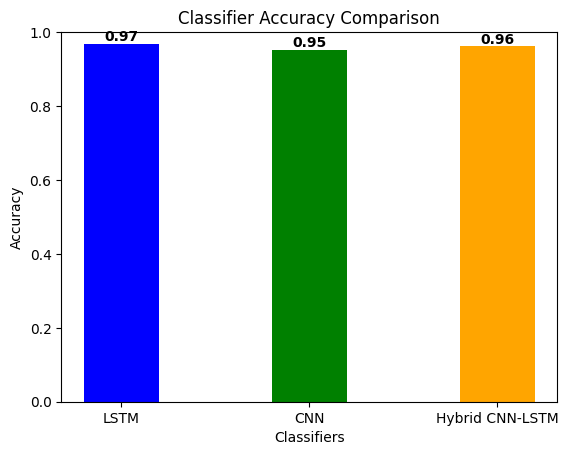

In [ ]:
import matplotlib.pyplot as plt

# Calculate accuracies
lstm_accuracy = model_lstm.evaluate(test_data, test_labels, verbose=0)[1]
cnn_accuracy = model_cnn.evaluate(test_data, test_labels_encoded, verbose=0)[1]
hybrid_accuracy = model_hybrid.evaluate(test_data, test_labels_encoded, verbose=0)[1]

# Create a bar graph with accuracy labels
classifiers = ['LSTM', 'CNN', 'Hybrid CNN-LSTM']
accuracies = [lstm_accuracy, cnn_accuracy, hybrid_accuracy]

fig, ax = plt.subplots()
bars = ax.bar(classifiers, accuracies, color=['blue', 'green', 'orange'], width=0.4)  # Adjust the width parameter

# Add accuracy values as labels on top of the bars
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 2), ha='center', va='bottom', color='black', fontweight='bold')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.ylim(0, 1)  # Set the y-axis limit to 0-1 for accuracy percentage
plt.show()

Metrics Graph

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


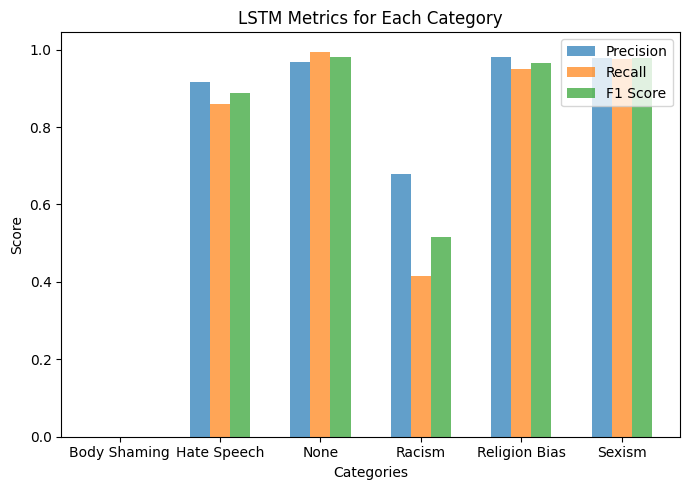

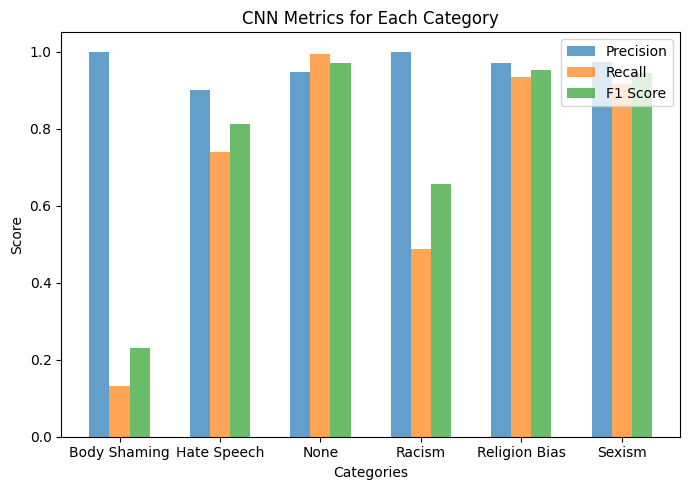

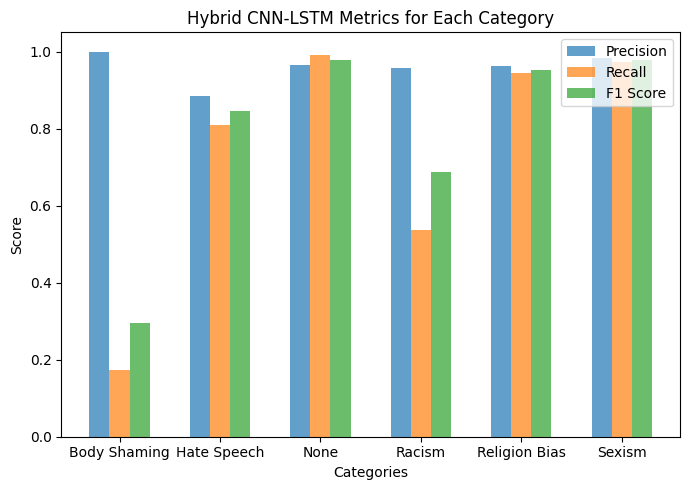

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def plot_metrics(classifier_name, precision, recall, f1, categories):
    bar_width = 0.2
    index = np.arange(len(categories))

    plt.figure(figsize=(7,5))

    plt.bar(index - bar_width, precision, bar_width, label='Precision', alpha=0.7)
    plt.bar(index, recall, bar_width, label='Recall', alpha=0.7)
    plt.bar(index + bar_width, f1, bar_width, label='F1 Score', alpha=0.7)

    plt.title(f'{classifier_name} Metrics for Each Category')
    plt.xlabel('Categories')
    plt.ylabel('Score')
    plt.xticks(index, categories)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# LSTM Metrics
lstm_metrics = precision_recall_fscore_support(test_labels, lstm_predicted_labels, labels=label_encoder.transform(label_encoder.classes_), average=None)
lstm_precision, lstm_recall, lstm_f1, _ = lstm_metrics

# CNN Metrics
cnn_metrics = precision_recall_fscore_support(test_labels, cnn_predicted_labels, labels=label_encoder.transform(label_encoder.classes_), average=None)
cnn_precision, cnn_recall, cnn_f1, _ = cnn_metrics

# Hybrid CNN-LSTM Metrics
hybrid_metrics = precision_recall_fscore_support(test_labels, hybrid_predicted_labels, labels=label_encoder.transform(label_encoder.classes_), average=None)
hybrid_precision, hybrid_recall, hybrid_f1, _ = hybrid_metrics

# Plot metrics for each classifier
plot_metrics('LSTM', lstm_precision, lstm_recall, lstm_f1, label_encoder.classes_)
plot_metrics('CNN', cnn_precision, cnn_recall, cnn_f1, label_encoder.classes_)
plot_metrics('Hybrid CNN-LSTM', hybrid_precision, hybrid_recall, hybrid_f1, label_encoder.classes_)


ROC- AUC Curve

106/106 [==============================] - 1s 9ms/step


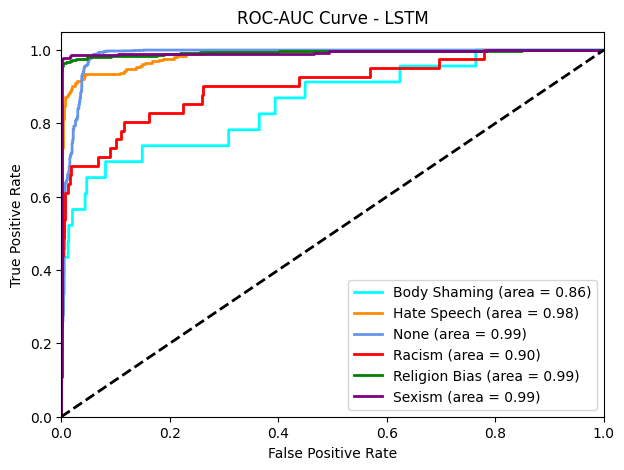

106/106 [==============================] - 1s 5ms/step


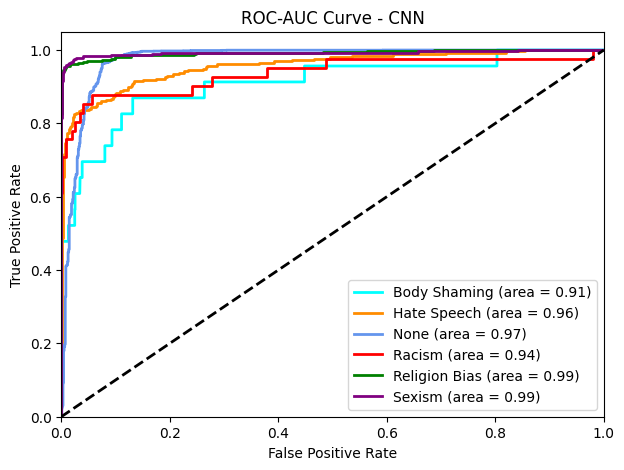

106/106 [==============================] - 2s 4ms/step


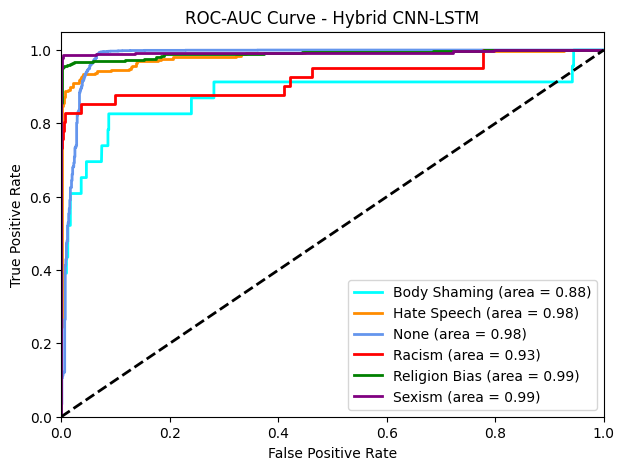

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Function to plot ROC-AUC curve
def plot_roc_auc(model, data, labels, label_encoder, model_name):
    # Binarize the labels
    labels_binarized = label_binarize(labels, classes=label_encoder.classes_)

    # Make predictions
    predictions = model.predict(data)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(label_encoder.classes_)):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], predictions[:, i])
        roc_auc[i] = roc_auc_score(labels_binarized[:, i], predictions[:, i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_binarized.ravel(), predictions.ravel())
    roc_auc["micro"] = roc_auc_score(labels_binarized, predictions, multi_class='ovr', average='micro')

    # Plot ROC curve
    plt.figure(figsize=(7, 5))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
    for i, color in zip(range(len(label_encoder.classes_)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC-AUC for LSTM model
plot_roc_auc(model_lstm, test_data, test_labels_encoded, label_encoder, model_name="LSTM")

# Plot ROC-AUC for CNN model
plot_roc_auc(model_cnn, test_data, test_labels_encoded, label_encoder, model_name="CNN")

# Plot ROC-AUC for Hybrid CNN-LSTM model
plot_roc_auc(model_hybrid, test_data, test_labels_encoded, label_encoder, model_name="Hybrid CNN-LSTM")


Confusion Graph

In [ ]:
!pip install scikit-learn
!pip install seaborn

106/106 [==============================] - 1s 6ms/step


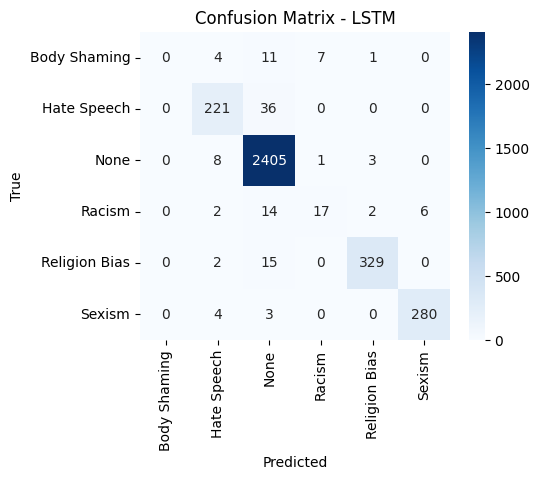

106/106 [==============================] - 0s 3ms/step


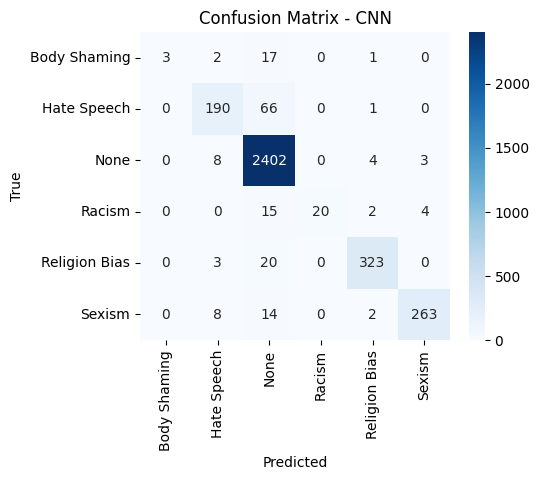

106/106 [==============================] - 0s 4ms/step


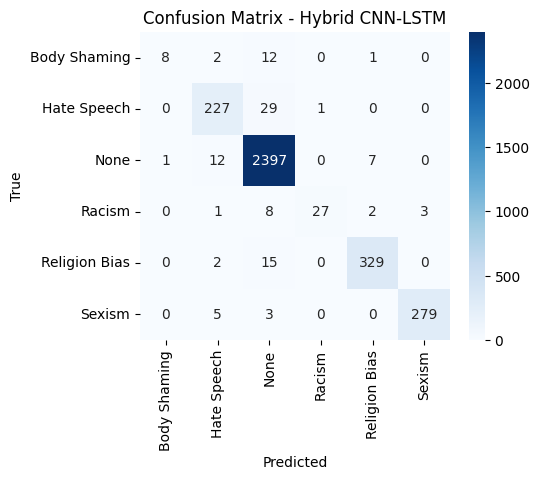

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix
def plot_model_confusion_matrix(model, test_data, test_labels, label_encoder, model_name):
    # Make predictions
    predictions = model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)

    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrix for LSTM model
plot_model_confusion_matrix(model_lstm, test_data, test_labels, label_encoder, model_name="LSTM")

# Plot confusion matrix for CNN model
plot_model_confusion_matrix(model_cnn, test_data, test_labels, label_encoder, model_name="CNN")

# Plot confusion matrix for Hybrid CNN-LSTM model
plot_model_confusion_matrix(model_hybrid, test_data, test_labels, label_encoder, model_name="Hybrid CNN-LSTM")